In [1024]:
from robot_vlp.config import RAW_DATA_DIR, FIGURES_DIR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, FormatStrFormatter



def normalize_angle_deg(angle):
    """Normalize an angle in degrees to the range [-180, 180]."""
    return (angle + 180) % 360 - 180

def normalize_angle_rad(angle):
    """Normalize an angle in radians to the range [-π, π]."""
    return (angle + np.pi) % (2 * np.pi) - np.pi



color_scheme = {
    'real': '#000000',   # black
    'rnn': '#1f77b4',    # blue
    'ekf':'#2ca02c',    # green
    'vlp':  '#ff7f0e',    # orange
    'encoder': '#7f7f7f' # grey
}

linestyles = {
    'rnn': '-',
    'ekf': '--',
    'vlp': ':',
    'encoder': '-.',
    'real':(0, (1, 1)) 
}

display_labels = {
    'rnn': 'LSTM',
    'encoder': 'Enc. Odom',
    'ekf': 'EKF',
    'vlp': 'VLP',
    'real': 'Real',
}

ONE_COL_WIDTH = 3.35
TWO_COL_WIDTH = 6.8
HIRES_DPI = 1200
SUPTITLE_FONT = 9
TITLE_FONT = 8
LABEL_FONT = 8
TICK_FONT = 7
LEGEND_FONT = 7





In [1025]:
def calc_errors(df, nav_method):
    if nav_method == 'rnn':
        loc_errors = rnn_loc_errs = np.sqrt((np.square(df['rnn_x'] - df['real_x']) + np.square(df['rnn_y'] - df['real_y']))[:].to_list())
        ang_errors = normalize_angle_deg((df['rnn_heading'] - df['real_heading']))
        
    elif nav_method == 'ekf':
        loc_errors = np.sqrt((np.square(df['ekf_x'] - df['real_x']) + np.square(df['ekf_y'] - df['real_y']))[:].to_list())
        ang_errors = normalize_angle_deg((df['ekf_heading'] - df['real_heading']))
    
    elif nav_method =='vlp':
        loc_errors = np.sqrt((np.square(df['vlp_x'] - df['real_x']) + np.square(df['vlp_y'] - df['real_y']))[:].to_list())
        ang_errors = normalize_angle_deg((df['vlp_heading'] - df['real_heading']))

    elif nav_method == 'enc':
        loc_errors = np.sqrt((np.square(df['encoder_x'] - df['real_x']) + np.square(df['encoder_y'] - df['real_y']))[:].to_list())
        ang_errors = normalize_angle_deg((df['encoder_heading'] - df['real_heading']))

    return ang_errors, loc_errors
        

In [1026]:


def plot_targets(ax):
    tar_pattern = np.array([
        [0.202, 0.287],
        [0.202, 0.622],
        [0.538, 0.622],
        [0.538, 0.287],
    ])
    for x, y in tar_pattern:
        circle = patches.Circle((x, y), radius=0.07, fill=False, edgecolor='k', linewidth=0.3, linestyle = '--', alpha = 0.3)
        ax.add_patch(circle)
    ax.plot(tar_pattern[:, 0], tar_pattern[:, 1], linestyle='', marker='.', markersize=1.0, linewidth=0.8, c='k', label='target', alpha = 0.3)

def plot_capture_targets(ax, exp):
    if exp == 'trans_and_rotate':
        tar_pattern = np.array([  # captured robot - trans & rotate
            [0.314, 0.4],
            [0.314, 0.622],
            [0.538, 0.622],
            [0.538, 0.4],
        ])
    elif exp == 'trans':
        tar_pattern = np.array([  # captured robot - trans only
            [0.202, 0.4],
            [0.202, 0.622],
            [0.426, 0.622],
            [0.426, 0.4],
        ])      
    elif exp == 'rotate':
        tar_pattern = np.array([  # captured robot - rotate only 90
            [0.37, 0.3345],
            [0.37, 0.5665],
            [0.594, 0.5665],
            [0.594, 0.3345],
        ])  
        
    for x, y in tar_pattern:
        circle = patches.Circle((x, y), radius=0.07, fill=False, edgecolor='k', linewidth=0.3, linestyle = '--', alpha = 0.3)
        ax.add_patch(circle)
    ax.plot(tar_pattern[:, 0], tar_pattern[:, 1], linestyle='', marker='.', markersize=1.0, linewidth=0.8, c='k', label='target', alpha = 0.3)



def plot_model_2x2(df, label_prefix, segments, fig_name):
    xlim = (0, 0.7)
    ylim = (0.1, 0.8)
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    titles = ["Path at ~0 steps", "Path at ~100 steps", "Path at ~200 steps", "Path at ~300 steps"]


    for idx, (start, end) in enumerate(segments):
        row, col = divmod(idx, 2)
        ax = axes[row][col]

        seg = df.iloc[start:end]
        ax.plot(seg['real_x'], seg['real_y'], label='real', linewidth=1.0, c = color_scheme['real'], marker = 'x', alpha = 0.6)
        ax.plot(seg[f'{label_prefix}_x'], seg[f'{label_prefix}_y'], label=display_labels.get(label_prefix, label_prefix), linewidth=1.0, c = color_scheme[label_prefix], marker =  '.', linestyle = '--')
        plot_targets(ax)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_aspect('equal')
        ax.set_title(titles[idx], fontsize=TITLE_FONT)
        if col == 0:
            ax.set_ylabel("Y position (m)", fontsize=LABEL_FONT)
        else:
            ax.set_yticklabels([])

        if row == 1:
            ax.set_xlabel("X position (m)", fontsize=LABEL_FONT)
        else:
            ax.set_xticklabels([])


    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    plt.savefig(FIGURES_DIR/f"live_navigation-{fig_name}.png", dpi=300)
    plt.show()
    plt.close()



def plot_first_last_segments(model_segments, path_label, fig_name):
    xlim = (0, 0.7)
    ylim = (0.1, 0.8)
    n_models = len(model_segments)
    n_rows = 2
    n_cols = n_models
    fig_height = 2.2
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(ONE_COL_WIDTH, fig_height)
    )
    axes = np.atleast_2d(axes)
    for ax in axes.flat:
        ax.tick_params(axis='both', labelsize=TICK_FONT - 3, length=2, width=0.6)
        ax.xaxis.set_major_locator(MaxNLocator(3))
        ax.yaxis.set_major_locator(MaxNLocator(3))
        ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
        ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

    row_titles = ["~0 steps", "~300 steps"]

    for col, (label_prefix, config) in enumerate(model_segments.items()):
        df = config['df']
        segments = config['segments']

        # Column titles = model names
        axes[0, col].set_title(display_labels.get(label_prefix, label_prefix), fontsize=TITLE_FONT)

        for row, seg_idx in enumerate([0, -1]):
            start, end = segments[seg_idx]
            ax = axes[row, col]
            seg = df.iloc[start:end]

            # highlight starting points
            ax.scatter(seg['real_x'].iloc[0], seg['real_y'].iloc[0], c='red', s=8, edgecolors='none', zorder=5)
            ax.scatter(seg[f"{label_prefix}_x"].iloc[0], seg[f"{label_prefix}_y"].iloc[0], c='red', s=8, edgecolors='none', zorder=5)

            ax.plot(
                seg['real_x'], seg['real_y'],
                label='Real', linewidth=0.7, c=color_scheme['real'], marker='x', markersize=2, alpha=0.6
            )
            ax.plot(
                seg[f"{label_prefix}_x"], seg[f"{label_prefix}_y"],
                label=display_labels.get(label_prefix, label_prefix),
                linewidth=0.7, c=color_scheme[label_prefix], marker='.', markersize=2, linestyle='--'
            )
            plot_targets(ax)

            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_aspect('equal')
            ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.5)

            if col == 0:
                ax.set_ylabel(f"Y(m){row_titles[row]}", fontsize=LABEL_FONT - 1, labelpad=1)
            else:
                # keep label space but hide text/ticks for non-left columns
                ax.set_ylabel(f"Y(m){row_titles[row]}", fontsize=LABEL_FONT - 1, labelpad=1, color='none')
                ax.tick_params(axis='y', labelleft=False, left=False)

            if row == n_rows - 1:
                ax.set_xlabel("X (m)", fontsize=LABEL_FONT - 1)
            else:
                ax.set_xticklabels([])

    legend_handles = [
        Line2D([0], [0], color=color_scheme['real'], marker='x', linestyle='-', linewidth=0.7, markersize=2, alpha=0.6, label='Real')
    ]
    for label_prefix in model_segments:
        legend_handles.append(
            Line2D([0], [0], color=color_scheme[label_prefix], linestyle='--', linewidth=0.7,
                   label=display_labels.get(label_prefix, label_prefix))
        )
    legend_handles.append(
        Line2D([0], [0], color='red', marker='o', linestyle='', markersize=4, label='Starting location')
    )

    fig.legend(handles=legend_handles, loc='lower center', ncol=3, frameon=False,
               bbox_to_anchor=(0.5, -0.05), fontsize=LEGEND_FONT)
    plt.subplots_adjust(hspace=-0.38, wspace=0.08, top=0.95, bottom=0.15, left=0.18, right=0.98)
    plt.savefig(FIGURES_DIR / f"live_navigation-{fig_name}.png", dpi=HIRES_DPI, bbox_inches='tight')
    plt.show()
    plt.close()


# Square path

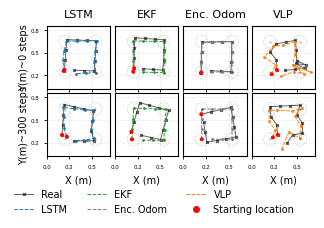

In [1027]:
rnn_square_df = pd.read_csv('final_rnn_square_m3_2.csv', index_col = [0])
enc_square_df = pd.read_csv('final_encoder_square_m3.csv', index_col = [0])
ekf_square_df = pd.read_csv('final_ekf_square_m3.csv', index_col = [0])
vlp_square_df = pd.read_csv('final_vlp_square_m3_2.csv', index_col = [0])



# plot_model_2x2(rnn_square_df, 'rnn', [(27, 39), (170, 182), (266, 278), (326, 338)], 'square_rnn_grid')
# plot_model_2x2(ekf_square_df, 'ekf', [(27, 39), (171, 183), (267, 279), (327, 339)], 'square_ekf_grid')
# plot_model_2x2(enc_square_df, 'encoder', [(3, 15), (99, 111), (195, 207), (291, 303)], 'square_enc_grid')
# plot_model_2x2(vlp_square_df, 'vlp', [(6, 19), (113, 125), (197, 209), (308, 320)], 'square_vlp_grid')



square_segments = {
    'rnn': {'df': rnn_square_df, 'segments': [(27, 39), (170, 182), (266, 278), (326, 338)]},
    'ekf': {'df': ekf_square_df, 'segments': [(27, 39), (171, 183), (267, 279), (327, 339)]},
    'encoder': {'df': enc_square_df, 'segments': [(3, 15), (99, 111), (195, 207), (291, 303)]},
    'vlp': {'df': vlp_square_df, 'segments': [(6, 19), (113, 125), (197, 209), (308, 320)]}
}

plot_first_last_segments(square_segments, 'Square', 'square_all_models_first_last')


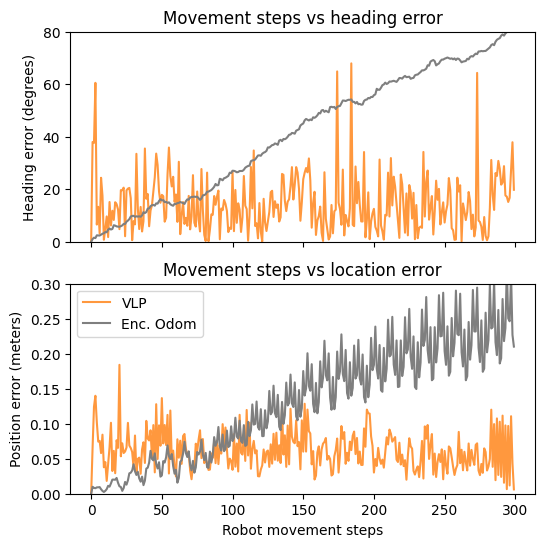

In [1028]:
rnn_square_df = pd.read_csv('final_rnn_square_m3_2.csv', index_col = [0])
enc_square_df = pd.read_csv('final_encoder_square_m3.csv', index_col = [0])
ekf_square_df = pd.read_csv('final_ekf_square_m3.csv', index_col = [0])
vlp_square_df = pd.read_csv('final_vlp_square_m3_2.csv', index_col = [0])

rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_square_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_square_df, 'ekf')
enc_ang_errs, enc_loc_errs = calc_errors(enc_square_df, 'enc')
vlp_ang_errs, vlp_loc_errs = calc_errors(vlp_square_df, 'vlp')



fig, axes = plt.subplots(2, 1, figsize=(6, 6))
axes[0].plot(vlp_ang_errs[:300].abs() , c = color_scheme['vlp'], label = 'VLP', alpha = 0.8)
axes[0].plot(enc_ang_errs[:300].abs() , c = color_scheme['encoder'], label = 'Enc. Odom')
axes[0].set_title('Movement steps vs heading error')
axes[0].set_ylabel('Heading error (degrees)')
axes[0].set_xticklabels([])

axes[1].plot(vlp_loc_errs[:300] , c = color_scheme['vlp'], label = 'VLP', alpha = 0.8)
axes[1].plot(enc_loc_errs[:300] , c = color_scheme['encoder'], label = 'Enc. Odom')
axes[1].set_title('Movement steps vs location error')
axes[1].set_ylabel('Position error (meters)')
axes[1].set_xlabel('Robot movement steps')
axes[1].legend()

axes[0].set_ylim(0,80)
axes[1].set_ylim(0, 0.3)

plt.savefig(FIGURES_DIR/f"live_navigation-square_vlp_enc_errs.png", dpi=300)



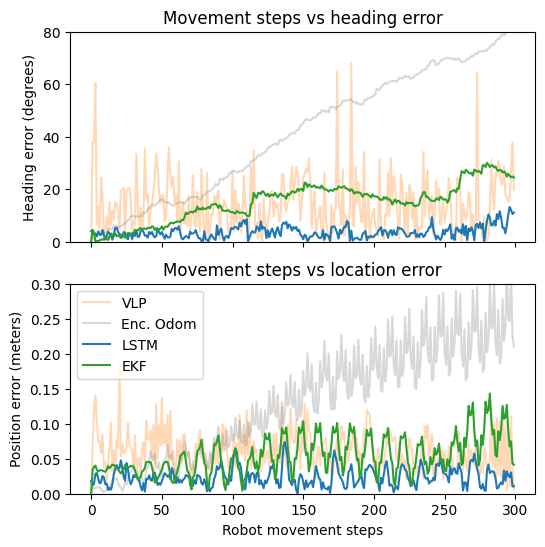

In [1029]:
rnn_square_df = pd.read_csv('final_rnn_square_m3_2.csv', index_col = [0])
enc_square_df = pd.read_csv('final_encoder_square_m3.csv', index_col = [0])
ekf_square_df = pd.read_csv('final_ekf_square_m3.csv', index_col = [0])
vlp_square_df = pd.read_csv('final_vlp_square_m3_2.csv', index_col = [0])

rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_square_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_square_df, 'ekf')
enc_ang_errs, enc_loc_errs = calc_errors(enc_square_df, 'enc')
vlp_ang_errs, vlp_loc_errs = calc_errors(vlp_square_df, 'vlp')


fig, axes = plt.subplots(2, 1, figsize=(6, 6))
axes[0].plot(vlp_ang_errs[:300].abs() , c = color_scheme['vlp'], label = 'VLP', alpha = 0.3)
axes[0].plot(enc_ang_errs[:300].abs() , c = color_scheme['encoder'], label = 'Enc. Odom', alpha = 0.3)
axes[0].plot(rnn_ang_errs[20:320].abs().values , c = color_scheme['rnn'], label = 'LSTM', alpha = 1)
axes[0].plot(ekf_ang_errs[:300].abs().values , c = color_scheme['ekf'], label = 'EKF', alpha = 1)
axes[0].set_title('Movement steps vs heading error')
axes[0].set_ylabel('Heading error (degrees)')
axes[0].set_xticklabels([])

axes[1].plot(vlp_loc_errs[:300] , c = color_scheme['vlp'], label = 'VLP', alpha = 0.3)
axes[1].plot(enc_loc_errs[:300] , c = color_scheme['encoder'], label = 'Enc. Odom', alpha = 0.3)
axes[1].plot(rnn_loc_errs[20:320] , c = color_scheme['rnn'], label = 'LSTM', alpha = 1)
axes[1].plot(ekf_loc_errs[:300] , c = color_scheme['ekf'], label = 'EKF', alpha = 1)
axes[1].set_title('Movement steps vs location error')
axes[1].set_ylabel('Position error (meters)')
axes[1].set_xlabel('Robot movement steps')
axes[1].legend()

axes[0].set_ylim(0,80)
axes[1].set_ylim(0, 0.3)

plt.savefig(FIGURES_DIR/f"live_navigation-all_square_errs.png", dpi=300)

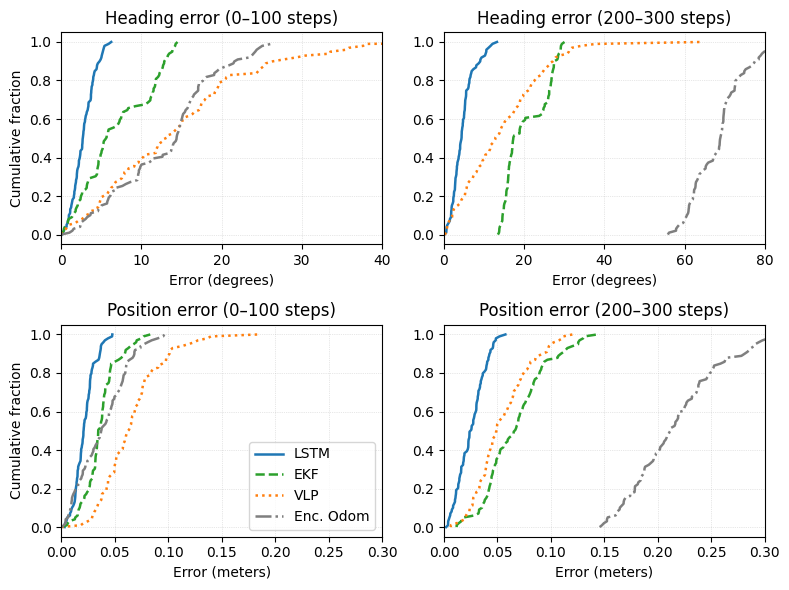

In [1030]:
rnn_square_df = pd.read_csv('final_rnn_square_m3_2.csv', index_col = [0])
enc_square_df = pd.read_csv('final_encoder_square_m3.csv', index_col = [0])
ekf_square_df = pd.read_csv('final_ekf_square_m3.csv', index_col = [0])
vlp_square_df = pd.read_csv('final_vlp_square_m3_2.csv', index_col = [0])

rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_square_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_square_df, 'ekf')
enc_ang_errs, enc_loc_errs = calc_errors(enc_square_df, 'enc')
vlp_ang_errs, vlp_loc_errs = calc_errors(vlp_square_df, 'vlp')

def plot_cdf(ax, data, label, color, linestyle):
    sorted_data = np.sort(data)
    yvals = np.linspace(0, 1, len(sorted_data))
    ax.plot(sorted_data, yvals, label=label, color=color, linestyle = linestyle, linewidth = 1.8)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
steps_early = slice(0, 100)
steps_late = slice(-100, None)

# CDFs: Heading Error (absolute, degrees)
for model, err_array in zip(
    ['rnn', 'ekf', 'vlp', 'encoder'],
    [rnn_ang_errs[20:320], ekf_ang_errs[:300], vlp_ang_errs[:300], enc_ang_errs[:300]]
):
    plot_cdf(axes[0,0], np.abs(err_array[steps_early]), display_labels.get(model, model), color_scheme[model], linestyle=linestyles[model])
    plot_cdf(axes[0,1], np.abs(err_array[steps_late]), display_labels.get(model, model), color_scheme[model], linestyle=linestyles[model])

axes[0,0].set_title("Heading error (0–100 steps)")
axes[0,1].set_title("Heading error (200–300 steps)")
axes[0,0].set_ylabel("Cumulative fraction")
axes[0,0].set_xlabel("Error (degrees)")
axes[0,1].set_xlabel("Error (degrees)")


# CDFs: Position Error
for model, err_array in zip(
    ['rnn', 'ekf', 'vlp', 'encoder'],
    [rnn_loc_errs[20:320], ekf_loc_errs[:300], vlp_loc_errs[:300], enc_loc_errs[:300]]
):
    plot_cdf(axes[1,0], err_array[steps_early], display_labels.get(model, model), color_scheme[model], linestyle=linestyles[model])
    plot_cdf(axes[1,1], err_array[steps_late], display_labels.get(model, model), color_scheme[model], linestyle=linestyles[model])

axes[1,0].set_title("Position error (0–100 steps)")
axes[1,1].set_title("Position error (200–300 steps)")
axes[1,0].set_ylabel("Cumulative fraction")
axes[1,0].set_xlabel("Error (meters)")
axes[1,1].set_xlabel("Error (meters)")
axes[1,0].legend()

for ax in axes.flat:
    ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)

axes[0, 0].set_xlim(0,40)
axes[0, 1].set_xlim(0,80)
axes[1, 0].set_xlim(0,0.3)
axes[1, 1].set_xlim(0,0.3)


plt.tight_layout()
plt.savefig(FIGURES_DIR / "live_navigation-square_cdf_comparison.png", dpi=300)
plt.show()


In [1031]:
import numpy as np
import pandas as pd

# --- keep your existing data loading + error computation ---
rnn_square_df = pd.read_csv('final_rnn_square_m3_2.csv', index_col=0)
enc_square_df = pd.read_csv('final_encoder_square_m3.csv', index_col=0)
ekf_square_df = pd.read_csv('final_ekf_square_m3.csv', index_col=0)
vlp_square_df = pd.read_csv('final_vlp_square_m3_2.csv', index_col=0)
rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_square_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_square_df, 'ekf')
enc_ang_errs, enc_loc_errs = calc_errors(enc_square_df, 'enc')
vlp_ang_errs, vlp_loc_errs = calc_errors(vlp_square_df, 'vlp')

# Use the same step windows as your CDFs
steps_early = slice(0, 100)
steps_late  = slice(-100, None)

# Match your per-model slicing windows for the 300-step comparison
heading_err_windows = {
    'rnn': np.abs(rnn_ang_errs[20:320]),
    'ekf': np.abs(ekf_ang_errs[:300]),
    'vlp': np.abs(vlp_ang_errs[:300]),
    'encoder': np.abs(enc_ang_errs[:300]),
}

position_err_windows = {
    'rnn': rnn_loc_errs[20:320],
    'ekf': ekf_loc_errs[:300],
    'vlp': vlp_loc_errs[:300],
    'encoder': enc_loc_errs[:300],
}

def _median_p90(x):
    x = np.asarray(x)
    if x.size == 0:
        return np.nan, np.nan
    return float(np.median(x)), float(np.percentile(x, 90))

def compute_split_median_p90(err_windows):
    """
    err_windows: dict {'model_name': array_like}
    Returns DataFrame indexed by MODEL with MultiIndex columns:
    (First 100, Median), (First 100, P90), (Last 100, Median), (Last 100, P90)
    """
    models = []
    data_rows = []
    for model, arr in err_windows.items():
        early = arr[steps_early]
        late  = arr[steps_late]
        med_e, p90_e = _median_p90(early)
        med_l, p90_l = _median_p90(late)
        models.append(display_labels.get(model, model))
        data_rows.append([med_e, p90_e, med_l, p90_l])

    cols = pd.MultiIndex.from_product(
        [['First 100', 'Last 100'], ['Median', 'P90']],
        names=['Split', 'Metric']
    )
    df = pd.DataFrame(data_rows, index=models, columns=cols)
    return df

heading_stats_df = compute_split_median_p90(heading_err_windows)
position_stats_df = compute_split_median_p90(position_err_windows)

# Display (rounded)
print("\n=== Heading (deg): Median & P90 ===")
print(heading_stats_df.round(4))
print("\n=== Position (m): Median & P90 ===")
print(position_stats_df.round(4))

# Optional: export for LaTeX tables
# heading_stats_df.round(4).to_csv('heading_median_p90_first_last100.csv')
# position_stats_df.round(4).to_csv('position_median_p90_first_last100.csv')
# heading_stats_df.round(4).to_latex('heading_median_p90_first_last100.tex', multirow=True)
# position_stats_df.round(4).to_latex('position_median_p90_first_last100.tex', multirow=True)



=== Heading (deg): Median & P90 ===
Split     First 100          Last 100         
Metric       Median      P90   Median      P90
LSTM         2.6797   4.7786   4.3596   9.0316
EKF          5.5784  12.8567  17.2874  27.5390
VLP         13.0029  26.4647  12.8159  27.1560
Enc. Odom   14.3786  21.6256  68.9085  77.6465

=== Position (m): Median & P90 ===
Split     First 100         Last 100        
Metric       Median     P90   Median     P90
LSTM         0.0208  0.0361   0.0247  0.0426
EKF          0.0346  0.0594   0.0660  0.1094
VLP          0.0625  0.1012   0.0492  0.0921
Enc. Odom    0.0374  0.0684   0.2118  0.2813


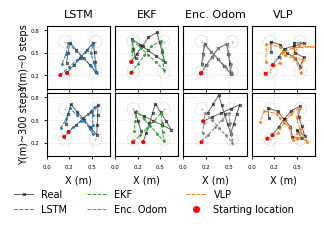

In [1032]:
rnn_hourglass_df = pd.read_csv('final_rnn_hourglass_m3.csv', index_col = [0])
enc_hourglass_df = pd.read_csv('final_encoder_hourglass_m3.csv', index_col = [0])
ekf_hourglass_df = pd.read_csv('final_ekf_hourglass_m3.csv', index_col = [0])
vlp_hourglass_df = pd.read_csv('final_vlp_hourglass_m3.csv', index_col = [0])



# plot_model_2x2(rnn_hourglass_df, 'rnn', [(32, 46), (130, 144), (228, 242), (327, 341)], 'hourglass_rnn_grid')
# plot_model_2x2(ekf_hourglass_df, 'ekf', [(4, 18), (102, 116), (201, 215), (299, 313)], 'hourglass_ekf_grid')
# plot_model_2x2(enc_hourglass_df, 'encoder', [(3, 17), (99, 113), (196, 210), (292, 306)], 'hourglass_enc_grid')
# plot_model_2x2(vlp_hourglass_df, 'vlp', [(27, 41), (134, 148), (208, 222), (313, 329)], 'hourglass_vlp_grid')
hourglass_segments = {
    'rnn': {'df': rnn_hourglass_df, 'segments': [(32, 46), (130, 144), (228, 242), (327, 341)]},
    'ekf': {'df': ekf_hourglass_df, 'segments': [(4, 18), (102, 116), (201, 215), (299, 313)]},
    'encoder': {'df': enc_hourglass_df, 'segments': [(3, 17), (99, 113), (196, 210), (292, 306)]},
    'vlp': {'df': vlp_hourglass_df, 'segments': [(27, 41), (134, 148), (208, 222), (313, 329)]}
}

plot_first_last_segments(hourglass_segments, 'Hourglass', 'hourglass_all_models_first_last')


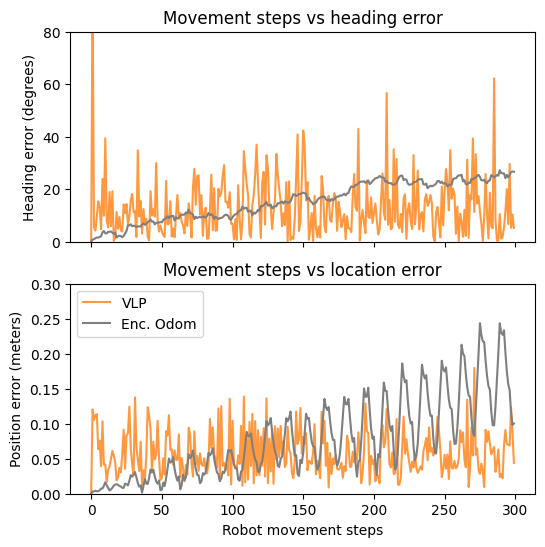

In [1033]:
rnn_hourglass_df = pd.read_csv('final_rnn_hourglass_m3.csv', index_col = [0])
enc_hourglass_df = pd.read_csv('final_encoder_hourglass_m3.csv', index_col = [0])
ekf_hourglass_df = pd.read_csv('final_ekf_hourglass_m3.csv', index_col = [0])
vlp_hourglass_df = pd.read_csv('final_vlp_hourglass_m3.csv', index_col = [0])

rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_hourglass_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_hourglass_df, 'ekf')
enc_ang_errs, enc_loc_errs = calc_errors(enc_hourglass_df, 'enc')
vlp_ang_errs, vlp_loc_errs = calc_errors(vlp_hourglass_df, 'vlp')



fig, axes = plt.subplots(2, 1, figsize=(6, 6))
axes[0].plot(vlp_ang_errs[:300].abs() , c = color_scheme['vlp'], label = 'VLP', alpha = 0.8)
axes[0].plot(enc_ang_errs[:300].abs() , c = color_scheme['encoder'], label = 'Enc. Odom')
axes[0].set_title('Movement steps vs heading error')
axes[0].set_ylabel('Heading error (degrees)')
axes[0].set_xticklabels([])


axes[1].plot(vlp_loc_errs[:300] , c = color_scheme['vlp'], label = 'VLP', alpha = 0.8)
axes[1].plot(enc_loc_errs[:300] , c = color_scheme['encoder'], label = 'Enc. Odom')
axes[1].set_title('Movement steps vs location error')
axes[1].set_ylabel('Position error (meters)')
axes[1].set_xlabel('Robot movement steps')
axes[1].legend()


axes[0].set_ylim(0,80)
axes[1].set_ylim(0, 0.3)

plt.savefig(FIGURES_DIR/f"live_navigation-hourglass_vlp_enc_errs.png", dpi=300)


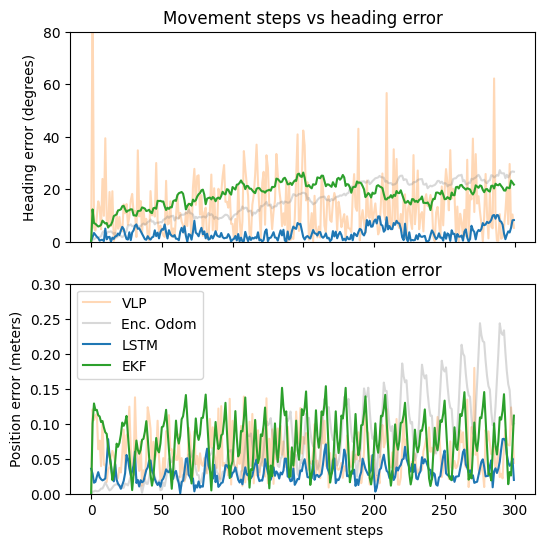

In [1034]:
rnn_hourglass_df = pd.read_csv('final_rnn_hourglass_m3.csv', index_col = [0])
enc_hourglass_df = pd.read_csv('final_encoder_hourglass_m3.csv', index_col = [0])
ekf_hourglass_df = pd.read_csv('final_ekf_hourglass_m3.csv', index_col = [0])
vlp_hourglass_df = pd.read_csv('final_vlp_hourglass_m3.csv', index_col = [0])

rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_hourglass_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_hourglass_df, 'ekf')
enc_ang_errs, enc_loc_errs = calc_errors(enc_hourglass_df, 'enc')
vlp_ang_errs, vlp_loc_errs = calc_errors(vlp_hourglass_df, 'vlp')




fig, axes = plt.subplots(2, 1, figsize=(6, 6))
axes[0].plot(vlp_ang_errs[:300].abs() , c = color_scheme['vlp'], label = 'VLP', alpha = 0.3)
axes[0].plot(enc_ang_errs[:300].abs() , c = color_scheme['encoder'], label = 'Enc. Odom', alpha = 0.3)
axes[0].plot(rnn_ang_errs[20:320].abs().values , c = color_scheme['rnn'], label = 'LSTM', alpha = 1)
axes[0].plot(ekf_ang_errs[:300].abs().values , c = color_scheme['ekf'], label = 'EKF', alpha = 1)
axes[0].set_title('Movement steps vs heading error')
axes[0].set_ylabel('Heading error (degrees)')
axes[0].set_xticklabels([])

axes[1].plot(vlp_loc_errs[:300] , c = color_scheme['vlp'], label = 'VLP', alpha = 0.3)
axes[1].plot(enc_loc_errs[:300] , c = color_scheme['encoder'], label = 'Enc. Odom', alpha = 0.3)
axes[1].plot(rnn_loc_errs[20:320] , c = color_scheme['rnn'], label = 'LSTM', alpha = 1)
axes[1].plot(ekf_loc_errs[:300] , c = color_scheme['ekf'], label = 'EKF', alpha = 1)
axes[1].set_title('Movement steps vs location error')
axes[1].set_ylabel('Position error (meters)')
axes[1].set_xlabel('Robot movement steps')
axes[1].legend()

axes[0].set_ylim(0,80)
axes[1].set_ylim(0, 0.3)

plt.savefig(FIGURES_DIR/f"live_navigation-all_hourglass_errs.png", dpi=300)

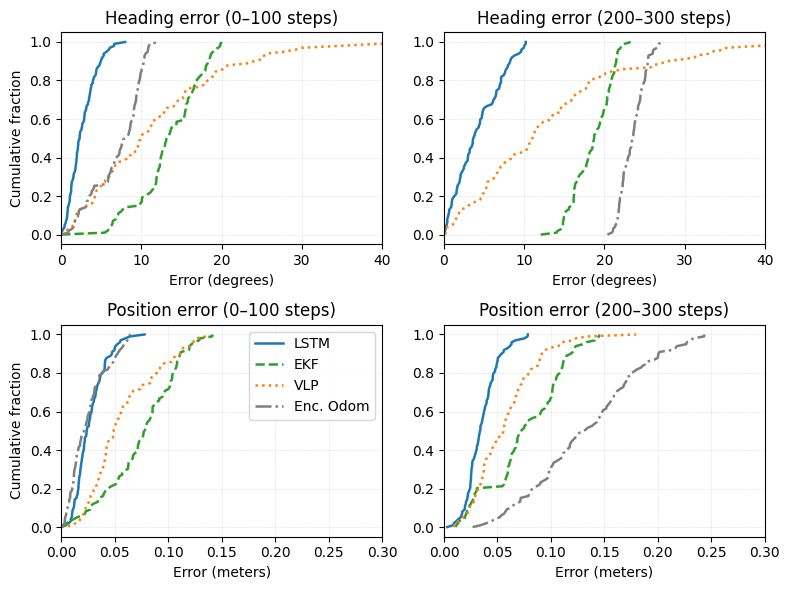

In [1035]:
rnn_hourglass_df = pd.read_csv('final_rnn_hourglass_m3.csv', index_col = [0])
enc_hourglass_df = pd.read_csv('final_encoder_hourglass_m3.csv', index_col = [0])
ekf_hourglass_df = pd.read_csv('final_ekf_hourglass_m3.csv', index_col = [0])
vlp_hourglass_df = pd.read_csv('final_vlp_hourglass_m3.csv', index_col = [0])

rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_hourglass_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_hourglass_df, 'ekf')
enc_ang_errs, enc_loc_errs = calc_errors(enc_hourglass_df, 'enc')
vlp_ang_errs, vlp_loc_errs = calc_errors(vlp_hourglass_df, 'vlp')

def plot_cdf(ax, data, label, color, linestyle):
    sorted_data = np.sort(data)
    yvals = np.linspace(0, 1, len(sorted_data))
    ax.plot(sorted_data, yvals, label=label, color=color, linestyle = linestyle, linewidth = 1.8)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
steps_early = slice(0, 100)
steps_late = slice(-100, None)

# CDFs: Heading Error (absolute, degrees)
for model, err_array in zip(
    ['rnn', 'ekf', 'vlp', 'encoder'],
    [rnn_ang_errs[20:320], ekf_ang_errs[:300], vlp_ang_errs[:300], enc_ang_errs[:300]]
):
    plot_cdf(axes[0,0], np.abs(err_array[steps_early]), display_labels.get(model, model), color_scheme[model], linestyle=linestyles[model])
    plot_cdf(axes[0,1], np.abs(err_array[steps_late]), display_labels.get(model, model), color_scheme[model], linestyle=linestyles[model])

axes[0,0].set_title("Heading error (0–100 steps)")
axes[0,1].set_title("Heading error (200–300 steps)")
axes[0,0].set_ylabel("Cumulative fraction")
axes[0,0].set_xlabel("Error (degrees)")
axes[0,1].set_xlabel("Error (degrees)")


# CDFs: Position Error
for model, err_array in zip(
    ['rnn', 'ekf', 'vlp', 'encoder'],
    [rnn_loc_errs[20:320], ekf_loc_errs[:300], vlp_loc_errs[:300], enc_loc_errs[:300]]
):
    plot_cdf(axes[1,0], err_array[steps_early], display_labels.get(model, model), color_scheme[model], linestyle=linestyles[model])
    plot_cdf(axes[1,1], err_array[steps_late], display_labels.get(model, model), color_scheme[model], linestyle=linestyles[model])

axes[1,0].set_title("Position error (0–100 steps)")
axes[1,1].set_title("Position error (200–300 steps)")
axes[1,0].set_ylabel("Cumulative fraction")
axes[1,0].set_xlabel("Error (meters)")
axes[1,1].set_xlabel("Error (meters)")
axes[1,0].legend()

for ax in axes.flat:
    ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)

axes[0, 0].set_xlim(0,40)
axes[0, 1].set_xlim(0,40)
axes[1, 0].set_xlim(0,0.3)
axes[1, 1].set_xlim(0,0.3)


plt.tight_layout()
plt.savefig(FIGURES_DIR / "live_navigation-hourglass_cdf_comparison.png", dpi=300)
plt.show()


In [1036]:
import numpy as np
import pandas as pd

# --- load hourglass results ---
rnn_hourglass_df = pd.read_csv('final_rnn_hourglass_m3.csv', index_col=0)
enc_hourglass_df = pd.read_csv('final_encoder_hourglass_m3.csv', index_col=0)
ekf_hourglass_df = pd.read_csv('final_ekf_hourglass_m3.csv', index_col=0)
vlp_hourglass_df = pd.read_csv('final_vlp_hourglass_m3.csv', index_col=0)

# assumes you already have calc_errors(runs_df, model_key) defined
rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_hourglass_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_hourglass_df, 'ekf')
enc_ang_errs, enc_loc_errs = calc_errors(enc_hourglass_df, 'enc')
vlp_ang_errs, vlp_loc_errs = calc_errors(vlp_hourglass_df, 'vlp')

# consistent with your CDF windows
steps_early = slice(0, 100)
steps_late  = slice(-100, None)

# match your per-model slicing (LSTM 20:320, others :300)
heading_err_windows = {
    'rnn': np.abs(rnn_ang_errs[20:320]),
    'ekf': np.abs(ekf_ang_errs[:300]),
    'vlp': np.abs(vlp_ang_errs[:300]),
    'encoder': np.abs(enc_ang_errs[:300]),
}
position_err_windows = {
    'rnn': rnn_loc_errs[20:320],
    'ekf': ekf_loc_errs[:300],
    'vlp': vlp_loc_errs[:300],
    'encoder': enc_loc_errs[:300],
}

def _median_p90(x):
    x = np.asarray(x)
    if x.size == 0:
        return np.nan, np.nan
    return float(np.median(x)), float(np.percentile(x, 90))

def compute_split_median_p90(err_windows):
    """
    Returns DataFrame indexed by MODEL with MultiIndex columns:
    (First 100, Median), (First 100, P90), (Last 100, Median), (Last 100, P90)
    """
    models = []
    data_rows = []
    for model, arr in err_windows.items():
        early = arr[steps_early]
        late  = arr[steps_late]
        med_e, p90_e = _median_p90(early)
        med_l, p90_l = _median_p90(late)
        models.append(display_labels.get(model, model))
        data_rows.append([med_e, p90_e, med_l, p90_l])

    cols = pd.MultiIndex.from_product(
        [['First 100', 'Last 100'], ['Median', 'P90']],
        names=['Split', 'Metric']
    )
    df = pd.DataFrame(data_rows, index=models, columns=cols)
    return df

# compute tables
heading_stats_hourglass_df  = compute_split_median_p90(heading_err_windows)
position_stats_hourglass_df = compute_split_median_p90(position_err_windows)

# display (rounded)
print("\n=== Hourglass — Heading (deg): Median & P90 ===")
print(heading_stats_hourglass_df.round(4))
print("\n=== Hourglass — Position (m): Median & P90 ===")
print(position_stats_hourglass_df.round(4))

# optional: export for LaTeX/tables
# heading_stats_hourglass_df.round(4).to_csv('hourglass_heading_median_p90_first_last100.csv')
# position_stats_hourglass_df.round(4).to_csv('hourglass_position_median_p90_first_last100.csv')
# heading_stats_hourglass_df.round(4).to_latex('hourglass_heading_median_p90_first_last100.tex', multirow=True)
# position_stats_hourglass_df.round(4).to_latex('hourglass_position_median_p90_first_last100.tex', multirow=True)


=== Hourglass — Heading (deg): Median & P90 ===
Split     First 100          Last 100         
Metric       Median      P90   Median      P90
LSTM         2.2783   4.9295   3.6554   8.2526
EKF         13.1367  18.3144  18.7154  21.4829
VLP          9.8728  24.0257  10.9934  27.8673
Enc. Odom    7.9174  10.2997  23.4864  25.4724

=== Hourglass — Position (m): Median & P90 ===
Split     First 100         Last 100        
Metric       Median     P90   Median     P90
LSTM         0.0238  0.0474   0.0338  0.0538
EKF          0.0778  0.1113   0.0722  0.1185
VLP          0.0490  0.1112   0.0556  0.0916
Enc. Odom    0.0213  0.0526   0.1308  0.2006


# Random path

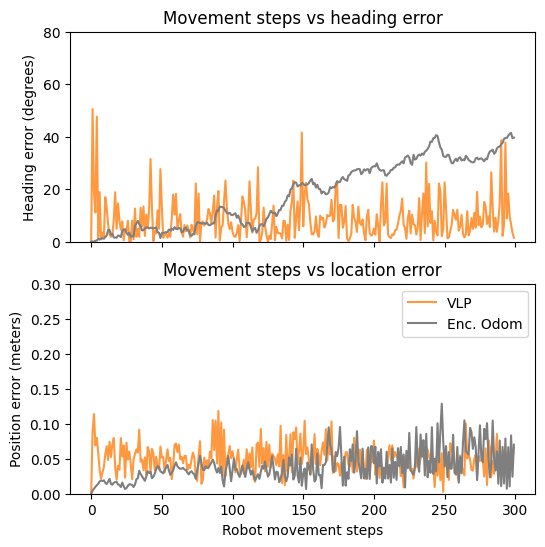

In [1037]:
rnn_random_df = pd.read_csv('final_rnn_random_m3_2.csv', index_col = [0])
enc_random_df = pd.read_csv('final_encoder_random_m3.csv', index_col = [0])
ekf_random_df = pd.read_csv('final_ekf_random_m3.csv', index_col = [0])
vlp_random_df = pd.read_csv('final_vlp_random_m3.csv', index_col = [0])

rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_random_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_random_df, 'ekf')
enc_ang_errs, enc_loc_errs = calc_errors(enc_random_df, 'enc')
vlp_ang_errs, vlp_loc_errs = calc_errors(vlp_random_df, 'vlp')


fig, axes = plt.subplots(2, 1, figsize=(6, 6))
axes[0].plot(vlp_ang_errs[:300].abs() , c = color_scheme['vlp'], label = 'VLP', alpha = 0.8)
axes[0].plot(enc_ang_errs[:300].abs() , c = color_scheme['encoder'], label = 'Enc. Odom')
axes[0].set_title('Movement steps vs heading error')
axes[0].set_ylabel('Heading error (degrees)')
axes[0].set_xticklabels([])

axes[1].plot(vlp_loc_errs[:300] , c = color_scheme['vlp'], label = 'VLP', alpha = 0.8)
axes[1].plot(enc_loc_errs[:300] , c = color_scheme['encoder'], label = 'Enc. Odom')
axes[1].set_title('Movement steps vs location error')
axes[1].set_ylabel('Position error (meters)')
axes[1].set_xlabel('Robot movement steps')
axes[1].legend()

axes[0].set_ylim(0,80)
axes[1].set_ylim(0, 0.3)

plt.savefig(FIGURES_DIR/f"live_navigation-random_vlp_enc_errs.png", dpi=300)

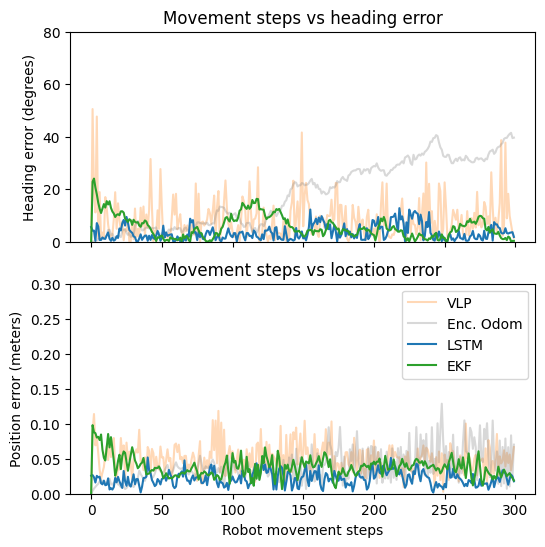

In [1038]:
rnn_random_df = pd.read_csv('final_rnn_random_m3_2.csv', index_col = [0])
enc_random_df = pd.read_csv('final_encoder_random_m3.csv', index_col = [0])
ekf_random_df = pd.read_csv('final_ekf_random_m3.csv', index_col = [0])
vlp_random_df = pd.read_csv('final_vlp_random_m3.csv', index_col = [0])

rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_random_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_random_df, 'ekf')
enc_ang_errs, enc_loc_errs = calc_errors(enc_random_df, 'enc')
vlp_ang_errs, vlp_loc_errs = calc_errors(vlp_random_df, 'vlp')


fig, axes = plt.subplots(2, 1, figsize=(6, 6))
axes[0].plot(vlp_ang_errs[:300].abs() , c = color_scheme['vlp'], label = 'VLP', alpha = 0.3)
axes[0].plot(enc_ang_errs[:300].abs() , c = color_scheme['encoder'], label = 'Enc. Odom', alpha = 0.3)
axes[0].plot(rnn_ang_errs[20:320].abs().values , c = color_scheme['rnn'], label = 'LSTM', alpha = 1)
axes[0].plot(ekf_ang_errs[:300].abs().values , c = color_scheme['ekf'], label = 'EKF', alpha = 1)
axes[0].set_title('Movement steps vs heading error')
axes[0].set_ylabel('Heading error (degrees)')
axes[0].set_xticklabels([])

axes[1].plot(vlp_loc_errs[:300] , c = color_scheme['vlp'], label = 'VLP', alpha = 0.3)
axes[1].plot(enc_loc_errs[:300] , c = color_scheme['encoder'], label = 'Enc. Odom', alpha = 0.3)
axes[1].plot(rnn_loc_errs[20:320] , c = color_scheme['rnn'], label = 'LSTM', alpha = 1)
axes[1].plot(ekf_loc_errs[:300] , c = color_scheme['ekf'], label = 'EKF', alpha = 1)
axes[1].set_title('Movement steps vs location error')
axes[1].set_ylabel('Position error (meters)')
axes[1].set_xlabel('Robot movement steps')
axes[1].legend()

axes[0].set_ylim(0,80)
axes[1].set_ylim(0, 0.3)

plt.savefig(FIGURES_DIR/f"live_navigation-all_random_errs.png", dpi=300)

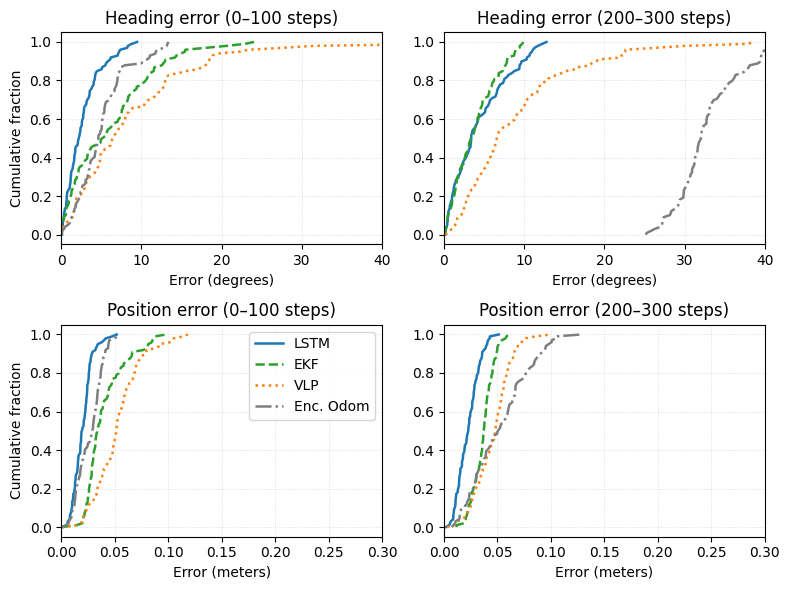

In [1039]:
rnn_random_df = pd.read_csv('final_rnn_random_m3_2.csv', index_col = [0])
enc_random_df = pd.read_csv('final_encoder_random_m3.csv', index_col = [0])
ekf_random_df = pd.read_csv('final_ekf_random_m3.csv', index_col = [0])
vlp_random_df = pd.read_csv('final_vlp_random_m3.csv', index_col = [0])

rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_random_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_random_df, 'ekf')
enc_ang_errs, enc_loc_errs = calc_errors(enc_random_df, 'enc')
vlp_ang_errs, vlp_loc_errs = calc_errors(vlp_random_df, 'vlp')

def plot_cdf(ax, data, label, color, linestyle):
    sorted_data = np.sort(data)
    yvals = np.linspace(0, 1, len(sorted_data))
    ax.plot(sorted_data, yvals, label=label, color=color, linestyle = linestyle, linewidth = 1.8)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
steps_early = slice(0, 100)
steps_late = slice(-100, None)

# CDFs: Heading Error (absolute, degrees)
for model, err_array in zip(
    ['rnn', 'ekf', 'vlp', 'encoder'],
    [rnn_ang_errs[20:320], ekf_ang_errs[:300], vlp_ang_errs[:300], enc_ang_errs[:300]]
):
    plot_cdf(axes[0,0], np.abs(err_array[steps_early]), display_labels.get(model, model), color_scheme[model], linestyle=linestyles[model])
    plot_cdf(axes[0,1], np.abs(err_array[steps_late]), display_labels.get(model, model), color_scheme[model], linestyle=linestyles[model])

axes[0,0].set_title("Heading error (0–100 steps)")
axes[0,1].set_title("Heading error (200–300 steps)")
axes[0,0].set_ylabel("Cumulative fraction")
axes[0,0].set_xlabel("Error (degrees)")
axes[0,1].set_xlabel("Error (degrees)")


# CDFs: Position Error
for model, err_array in zip(
    ['rnn', 'ekf', 'vlp', 'encoder'],
    [rnn_loc_errs[20:320], ekf_loc_errs[:300], vlp_loc_errs[:300], enc_loc_errs[:300]]
):
    plot_cdf(axes[1,0], err_array[steps_early], display_labels.get(model, model), color_scheme[model], linestyle=linestyles[model])
    plot_cdf(axes[1,1], err_array[steps_late], display_labels.get(model, model), color_scheme[model], linestyle=linestyles[model])

axes[1,0].set_title("Position error (0–100 steps)")
axes[1,1].set_title("Position error (200–300 steps)")
axes[1,0].set_ylabel("Cumulative fraction")
axes[1,0].set_xlabel("Error (meters)")
axes[1,1].set_xlabel("Error (meters)")
axes[1,0].legend()

for ax in axes.flat:
    ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)

    
axes[0, 0].set_xlim(0,40)
axes[0, 1].set_xlim(0,40)
axes[1, 0].set_xlim(0,0.3)
axes[1, 1].set_xlim(0,0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "live_navigation-random_cdf_comparison.png", dpi=300)
plt.show()

In [1040]:
import numpy as np
import pandas as pd

# --- load random results ---
rnn_random_df = pd.read_csv('final_rnn_random_m3_2.csv', index_col=0)
enc_random_df = pd.read_csv('final_encoder_random_m3.csv', index_col=0)
ekf_random_df = pd.read_csv('final_ekf_random_m3.csv', index_col=0)
vlp_random_df = pd.read_csv('final_vlp_random_m3.csv', index_col=0)

# assumes calc_errors(df, model_key) is defined in your session
rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_random_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_random_df, 'ekf')
enc_ang_errs, enc_loc_errs = calc_errors(enc_random_df, 'enc')
vlp_ang_errs, vlp_loc_errs = calc_errors(vlp_random_df, 'vlp')

# consistent with your CDF windows
steps_early = slice(0, 100)
steps_late  = slice(-100, None)

# match your per-model slicing (LSTM 20:320, others :300)
heading_err_windows = {
    'rnn': np.abs(rnn_ang_errs[20:320]),
    'ekf': np.abs(ekf_ang_errs[:300]),
    'vlp': np.abs(vlp_ang_errs[:300]),
    'encoder': np.abs(enc_ang_errs[:300]),
}
position_err_windows = {
    'rnn': rnn_loc_errs[20:320],
    'ekf': ekf_loc_errs[:300],
    'vlp': vlp_loc_errs[:300],
    'encoder': enc_loc_errs[:300],
}

def _median_p90(x):
    x = np.asarray(x)
    if x.size == 0:
        return np.nan, np.nan
    return float(np.median(x)), float(np.percentile(x, 90))

def compute_split_median_p90(err_windows):
    """
    Returns DataFrame indexed by MODEL with MultiIndex columns:
    (First 100, Median), (First 100, P90), (Last 100, Median), (Last 100, P90)
    """
    models, data_rows = [], []
    for model, arr in err_windows.items():
        early = arr[steps_early]
        late  = arr[steps_late]
        med_e, p90_e = _median_p90(early)
        med_l, p90_l = _median_p90(late)
        models.append(display_labels.get(model, model))
        data_rows.append([med_e, p90_e, med_l, p90_l])

    cols = pd.MultiIndex.from_product(
        [['First 100', 'Last 100'], ['Median', 'P90']],
        names=['Split', 'Metric']
    )
    return pd.DataFrame(data_rows, index=models, columns=cols)

# compute tables
heading_stats_random_df  = compute_split_median_p90(heading_err_windows)
position_stats_random_df = compute_split_median_p90(position_err_windows)

# display (rounded)
print("\n=== Random — Heading (deg): Median & P90 ===")
print(heading_stats_random_df.round(4))
print("\n=== Random — Position (m): Median & P90 ===")
print(position_stats_random_df.round(4))

# optional: export for LaTeX/CSV
# heading_stats_random_df.round(4).to_csv('random_heading_median_p90_first_last100.csv')
# position_stats_random_df.round(4).to_csv('random_position_median_p90_first_last100.csv')
# heading_stats_random_df.round(4).to_latex('random_heading_median_p90_first_last100.tex', multirow=True)
# position_stats_random_df.round(4).to_latex('random_position_median_p90_first_last100.tex', multirow=True)


=== Random — Heading (deg): Median & P90 ===
Split     First 100          Last 100         
Metric       Median      P90   Median      P90
LSTM         2.1776   5.8199   3.3927   9.7313
EKF          5.1074  12.9303   3.3747   7.8478
VLP          6.4259  18.3149   6.5805  19.0174
Enc. Odom    4.6237  10.2712  32.0293  39.4441

=== Random — Position (m): Median & P90 ===
Split     First 100         Last 100        
Metric       Median     P90   Median     P90
LSTM         0.0192  0.0286   0.0227  0.0357
EKF          0.0338  0.0662   0.0371  0.0491
VLP          0.0514  0.0795   0.0480  0.0657
Enc. Odom    0.0291  0.0411   0.0505  0.0899


## Inter model comparison

Loaded testing_last100_errors.npz and added Training rows.


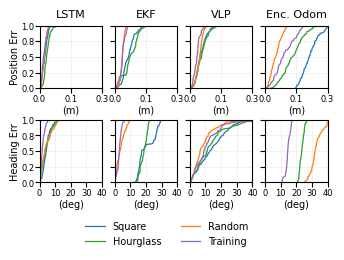

In [1041]:
# === CDF-by-model, first vs last 100 steps (with Training/testing split if available) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

if 'FIGURES_DIR' not in globals():
    FIGURES_DIR = Path('figures')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

pattern_dfs = {
    'square': {
        'rnn': rnn_square_df,
        'ekf': ekf_square_df,
        'encoder': enc_square_df,
        'vlp': vlp_square_df,
    },
    'hourglass': {
        'rnn': rnn_hourglass_df,
        'ekf': ekf_hourglass_df,
        'encoder': enc_hourglass_df,
        'vlp': vlp_hourglass_df,
    },
    'random': {
        'rnn': rnn_random_df,
        'ekf': ekf_random_df,
        'encoder': enc_random_df,
        'vlp': vlp_random_df,
    },
}

model_key_map = {'rnn': 'rnn', 'ekf': 'ekf', 'encoder': 'enc', 'vlp': 'vlp'}
models = ['rnn', 'ekf', 'vlp', 'encoder']
model_titles = {'rnn':'LSTM', 'ekf':'EKF', 'vlp':'VLP', 'encoder':'Enc. Odom'}

color_scheme = {
    'real': '#000000',
    'rnn': '#1f77b4',
    'ekf': '#2ca02c',
    'vlp': '#ff7f0e',
    'encoder': '#7f7f7f',
}

pattern_colors = {
    'square':    '#1f77b4',
    'hourglass': '#2ca02c',
    'random':    '#ff7f0e',
    'testing':   '#9467bd',
}
pattern_labels = {
    'square': 'Square',
    'hourglass': 'Hourglass',
    'random': 'Random',
    'testing': 'Training',
}

pattern_order = ['square', 'hourglass', 'random']


def _window_for_model(arr, model_key):
    arr = np.asarray(arr)
    return arr[20:320] if model_key == 'rnn' else arr[:300]


def _build_windows(heading_arr, position_arr, model_key):
    heading_window = _window_for_model(heading_arr, model_key)
    position_window = _window_for_model(position_arr, model_key)
    return {
        'heading': {
            'early': np.abs(heading_window[:100]),
            'late':  np.abs(heading_window[-100:]),
        },
        'position': {
            'early': position_window[:100],
            'late':  position_window[-100:],
        },
    }


errors = {}
for pattern, model_frames in pattern_dfs.items():
    errors[pattern] = {}
    for model, df in model_frames.items():
        heading_arr, position_arr = calc_errors(df, model_key_map[model])
        errors[pattern][model] = _build_windows(heading_arr, position_arr, model_key_map[model])


testing_npz_path = Path('testing_last100_errors.npz')
if testing_npz_path.exists():
    npz = np.load(testing_npz_path)
    errors['testing'] = {}
    for model in models:
        errors['testing'][model] = {
            'heading': {
                'early': np.abs(np.asarray(npz[f'{model}_heading_first100'])),
                'late':  np.abs(np.asarray(npz[f'{model}_heading'])),
            },
            'position': {
                'early': np.asarray(npz[f'{model}_position_first100']),
                'late':  np.asarray(npz[f'{model}_position']),
            },
        }
    pattern_order.append('testing')
    print('Loaded testing_last100_errors.npz and added Training rows.')
else:
    print('testing_last100_errors.npz not -- proceeding without Training performance.')


def _get_window(pattern, model, metric, window_key):
    return np.asarray(errors[pattern][model][metric][window_key])


def plot_cdf(ax, data, label, color, linestyle="-"):
    data = np.asarray(data)
    sorted_data = np.sort(data)
    yvals = np.linspace(0.0, 1.0, len(sorted_data))
    ax.plot(sorted_data, yvals, label=label, color=color, linestyle=linestyle, linewidth=0.9, alpha=1.0)


metrics = ['position', 'heading']
row_titles = {'position': 'Position Err', 'heading': 'Heading Err'}
x_limits = {'position': (0, 0.3), 'heading': (0, 40)}
x_labels = {'position': '(m)', 'heading': '(deg)'}

fig, axes = plt.subplots(len(metrics), len(models), figsize=(ONE_COL_WIDTH, 2.6), sharex='row')
axes = np.asarray(axes)
for r, metric in enumerate(metrics):
    for c, model in enumerate(models):
        ax = axes[r, c]
        for pattern in pattern_order:
            arr = _get_window(pattern, model, metric, 'late')
            plot_cdf(ax, arr, label=pattern_labels[pattern], color=pattern_colors.get(pattern, '#999999'), linestyle='-')
        ax.set_xlim(x_limits[metric])
        ax.set_ylim(0, 1)
        y_ticks = np.linspace(0, 1, 5)
        ax.set_yticks(y_ticks)
        ax.tick_params(axis='y', labelsize=TICK_FONT - 1, pad=0)
        ax.tick_params(axis='x', labelsize=TICK_FONT - 1, pad=1)
        ticks = [0, 10, 20, 30, 40] if metric == 'heading' else np.linspace(x_limits[metric][0], x_limits[metric][1], 3)
        ax.set_xticks(ticks)
        if metric == 'heading':
            ax.set_xticklabels([f"{int(t)}" for t in ticks], fontsize=TICK_FONT - 1)
        else:
            ax.set_xticklabels([f"{t:.1f}" for t in ticks], fontsize=TICK_FONT - 1)
        ax.set_xlabel(x_labels[metric], fontsize=LABEL_FONT - 1, labelpad=1)
        if c == 0:
            ax.set_ylabel(row_titles[metric], fontsize=LABEL_FONT - 1, labelpad=1)
            ax.set_yticklabels([f"{t:.1f}" for t in y_ticks], fontsize=TICK_FONT - 1)
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)
        if hasattr(ax, 'set_box_aspect'):
            ax.set_box_aspect(1)
        else:
            ax.set_aspect('equal', adjustable='box')
        if r == 0:
            ax.set_title(model_titles[model], fontsize=TITLE_FONT)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, fontsize=LEGEND_FONT, bbox_to_anchor=(0.5, -0.04))
plt.subplots_adjust(hspace=0.01, wspace=0.2, left=0.12, right=0.98, bottom=0.18, top=0.9)
plt.savefig(FIGURES_DIR / 'live_navigation-cdf_by_model_heading_position_grid.png', dpi=HIRES_DPI, bbox_inches='tight')
plt.show()


In [1042]:
FIGURES_DIR

PosixPath('/Users/tyrelglass/PhD/Repositories/robot-vlp/reports/67c4db6d4bd74c401fb0585d/figures')

In [1043]:
import numpy as np
import pandas as pd

color_scheme = {
    'real': '#000000',   # black
    'rnn': '#1f77b4',    # blue
    'ekf':'#2ca02c',    # green
    'vlp':  '#ff7f0e',    # orange
    'encoder': '#7f7f7f' # grey
}

linestyles = {
    'rnn': '-',
    'ekf': '--',
    'vlp': ':',
    'encoder': '-.',
    'real':(0, (1, 1)) 
}

models_order = ['rnn','ekf','encoder','vlp']
cols = pd.MultiIndex.from_product([
    ['median','p90'],
    models_order
], names=['Metric','Model'])
rows = ['square','hourglass','random','training']

def _median_p90(x):
    arr = np.asarray(x)
    if arr.size == 0:
        return np.nan, np.nan
    return float(np.median(arr)), float(np.percentile(arr, 90))

heading_rows = []
position_rows = []
for pattern in rows:
    if pattern not in errors:
        heading_rows.append([np.nan] * len(cols))
        position_rows.append([np.nan] * len(cols))
        continue
    med_heading, p90_heading = [], []
    med_position, p90_position = [], []
    for m in models_order:
        windows = errors[pattern][m]
        mh, ph = _median_p90(windows['heading']['late'])
        mp, pp = _median_p90(windows['position']['late'])
        med_heading.append(mh);    p90_heading.append(ph)
        med_position.append(mp);   p90_position.append(pp)
    heading_rows.append(med_heading + p90_heading)
    position_rows.append(med_position + p90_position)

heading_stats_df  = pd.DataFrame(heading_rows,  index=rows, columns=cols)
position_stats_df = pd.DataFrame(position_rows, index=rows, columns=cols)



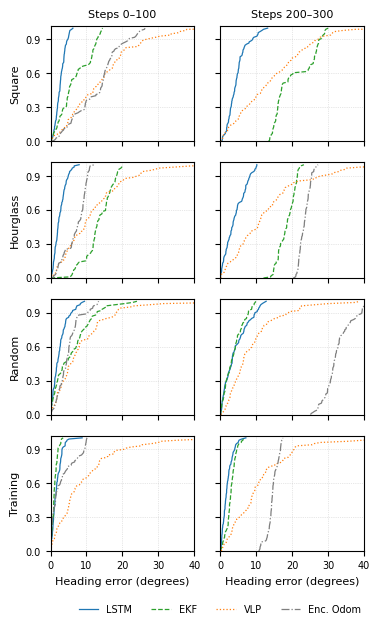

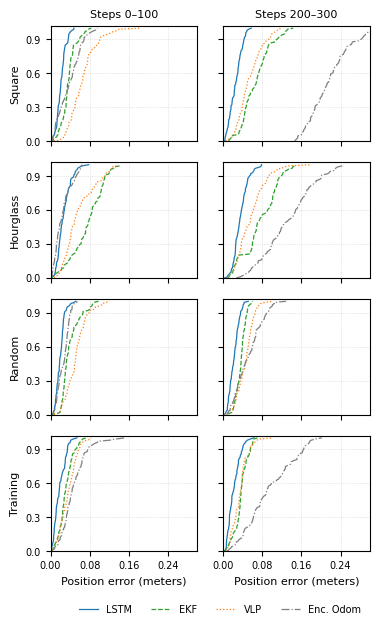

In [1044]:
color_scheme = {
    'real': '#000000',   # black
    'rnn': '#1f77b4',    # blue
    'ekf':'#2ca02c',    # green
    'vlp':  '#ff7f0e',    # orange
    'encoder': '#7f7f7f' # grey
}
linestyles = {
    'rnn': '-',
    'ekf': '--',
    'vlp': ':',
    'encoder': '-.',
    'real':(0, (1, 1)) 
}

# ---------------------------------------------------------------------
# Consolidated path-centric CDFs (rows=paths, columns=early vs late)
# ---------------------------------------------------------------------
path_rows = ['square', 'hourglass', 'random']
if 'testing' in errors:
    path_rows.append('testing')
path_labels = {
    'square': 'Square',
    'hourglass': 'Hourglass',
    'random': 'Random',
    'testing': 'Training',
}
window_titles = {
    'early': 'Steps 0–100',
    'late': 'Steps 200–300',
}

def _extract_window(errors_dict, pattern, model, kind, window_key):
    return np.asarray(errors_dict[pattern][model][kind][window_key])


def plot_cdf_by_path(kind, xlabel, filename, xlim):
    n_rows = len(path_rows)
    fig_height = max(5.25, 1.785 * n_rows)
    fig, axes = plt.subplots(n_rows, 2, figsize=(5.0, fig_height), sharex=True, sharey=True)
    axes = np.atleast_2d(axes)

    for ax in axes.flat:
        ax.tick_params(axis='both', labelsize=7)
        ax.xaxis.set_major_locator(MaxNLocator(4))
        ax.yaxis.set_major_locator(MaxNLocator(4))
        ax.set_ylim(0, 1.02)
        ax.set_aspect('auto')
        ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)

    for r, pattern in enumerate(path_rows):
        for c, window_key in enumerate(['early', 'late']):
            ax = axes[r, c]
            plotted_any = False
            for model in models:
                data = _extract_window(errors, pattern, model, kind, window_key)
                if data is None or len(data) == 0:
                    continue
                plotted_any = True
                plot_cdf(
                    ax,
                    data,
                    label=model_titles[model],
                    color=color_scheme[model], 
                    linestyle=linestyles[model],
                )
            ax.set_xlim(xlim)
            if r == n_rows - 1:
                ax.set_xlabel(xlabel, fontsize=8)
            if c == 0:
                ax.set_ylabel(path_labels.get(pattern, pattern.title()), fontsize=8)
            if r == 0:
                ax.set_title(window_titles[window_key], fontsize=8)
            if not plotted_any:
                ax.text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=7, color='#666666')

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(models), frameon=False, fontsize=7, bbox_to_anchor=(0.65, 0.08))
    fig.tight_layout(rect=[0.2, 0.11, 0.98, 0.96])
    plt.savefig(FIGURES_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()


plot_cdf_by_path('heading', 'Heading error (degrees)', 'live_navigation-cdf_by_path_heading_first_last.png', (0, 40))
plot_cdf_by_path('position', 'Position error (meters)', 'live_navigation-cdf_by_path_position_first_last.png', (0, 0.3))


In [1045]:
import numpy as np
import pandas as pd
from pathlib import Path

# --- helper: per-model window, last-100 extraction ---
def _window_for_model(arr, model_key):
    return arr[20:320] if model_key == 'rnn' else arr[:300]

def _last100_heading(arr, model_key):
    return np.abs(_window_for_model(arr, model_key))[-100:]

def _last100_position(arr, model_key):
    return _window_for_model(arr, model_key)[-100:]

def _median_p90(x):
    x = np.asarray(x)
    if x.size == 0:
        return np.nan, np.nan
    return float(np.median(x)), float(np.percentile(x, 90))

# --- models & column layout ---
models_order = ['rnn','ekf','encoder','vlp']
cols = pd.MultiIndex.from_product(
    [['median','p90'], models_order],
    names=['Metric','Model']
)

# --- Build 'errors' for square/hourglass/random from your dataframes ---
# Assumes you already have calc_errors(df, key) and the *_df objects (square/hourglass/random) loaded.
errors = {
    'square': {
        'rnn':     calc_errors(rnn_square_df, 'rnn'),
        'ekf':     calc_errors(ekf_square_df, 'ekf'),
        'encoder': calc_errors(enc_square_df, 'enc'),
        'vlp':     calc_errors(vlp_square_df, 'vlp'),
    },
    'hourglass': {
        'rnn':     calc_errors(rnn_hourglass_df, 'rnn'),
        'ekf':     calc_errors(ekf_hourglass_df, 'ekf'),
        'encoder': calc_errors(enc_hourglass_df, 'enc'),
        'vlp':     calc_errors(vlp_hourglass_df, 'vlp'),
    },
    'random': {
        'rnn':     calc_errors(rnn_random_df, 'rnn'),
        'ekf':     calc_errors(ekf_random_df, 'ekf'),
        'encoder': calc_errors(enc_random_df, 'enc'),
        'vlp':     calc_errors(vlp_random_df, 'vlp'),
    },
}

# --- Optionally add "training" (from testing_last100_errors.npz exported earlier) ---
# Note: the NPZ already contains last-100 arrays; heading is already abs().
npz_path = Path('testing_last100_errors.npz')
have_training = npz_path.exists()
if have_training:
    npz = np.load(npz_path)
    errors['training'] = {
        'rnn':     (npz['rnn_heading'],     npz['rnn_position']),
        'ekf':     (npz['ekf_heading'],     npz['ekf_position']),
        'encoder': (npz['encoder_heading'], npz['encoder_position']),
        'vlp':     (npz['vlp_heading'],     npz['vlp_position']),
    }
else:
    print("Note: testing_last100_errors.npz not found — the 'training' row will be NaN.")

# --- rows order as requested ---
rows = ['square','hourglass','random','training']

# --- Compute tables ---
heading_rows = []
position_rows = []

for pattern in rows:
    if pattern not in errors:
        # fill with NaNs if 'training' missing, etc.
        heading_rows.append([np.nan] * (2*len(models_order)))
        position_rows.append([np.nan] * (2*len(models_order)))
        continue

    # One row: [median.rnn, median.ekf, median.encoder, median.vlp, p90.rnn, ...] ? NO.
    # We want top-level ['median','p90'] then subcolumns models; so build in that order.
    med_heading, p90_heading = [], []
    med_position, p90_position = [], []

    for m in models_order:
        h_arr, p_arr = errors[pattern][m]

        if pattern == 'training':
            # already last-100; heading already abs()
            h_last100 = np.asarray(h_arr)
            p_last100 = np.asarray(p_arr)
        else:
            h_last100 = _last100_heading(h_arr, m)
            p_last100 = _last100_position(p_arr, m)

        mh, ph = _median_p90(h_last100)
        mp, pp = _median_p90(p_last100)

        med_heading.append(mh);     p90_heading.append(ph)
        med_position.append(mp);    p90_position.append(pp)

    # Concatenate in the order of the MultiIndex: ['median', models...] then ['p90', models...]
    heading_rows.append(med_heading + p90_heading)
    position_rows.append(med_position + p90_position)

# Build DataFrames
heading_stats_df  = pd.DataFrame(heading_rows,  index=rows, columns=cols)
position_stats_df = pd.DataFrame(position_rows, index=rows, columns=cols)

# --- Display (rounded) ---
print("\n=== Heading (deg): last 100 — rows=['square','hourglass','random','training'] ===")
print(heading_stats_df.round(4))
print("\n=== Position (m): last 100 — rows=['square','hourglass','random','training'] ===")
print(position_stats_df.round(4))

# --- Optional: export to CSV / LaTeX ---
# heading_stats_df.round(4).to_csv('cdf_last100_heading_by_pattern.csv')
# position_stats_df.round(4).to_csv('cdf_last100_position_by_pattern.csv')
# heading_stats_df.round(4).to_latex('cdf_last100_heading_by_pattern.tex', multirow=True)
# position_stats_df.round(4).to_latex('cdf_last100_position_by_pattern.tex', multirow=True)


=== Heading (deg): last 100 — rows=['square','hourglass','random','training'] ===
Metric     median                                p90                    \
Model         rnn      ekf  encoder      vlp     rnn      ekf  encoder   
square     4.3596  17.2874  68.9085  12.8159  9.0316  27.5390  77.6465   
hourglass  3.6554  18.7154  23.4864  10.9934  8.2526  21.4829  25.4724   
random     3.3927   3.3747  32.0293   6.5805  9.7313   7.8478  39.4441   
training   1.6755   2.9425  14.5256   8.9357  4.0533   4.6258  16.7792   

Metric              
Model          vlp  
square     27.1560  
hourglass  27.8673  
random     19.0174  
training   20.5916  

=== Position (m): last 100 — rows=['square','hourglass','random','training'] ===
Metric     median                             p90                        
Model         rnn     ekf encoder     vlp     rnn     ekf encoder     vlp
square     0.0247  0.0660  0.2118  0.0492  0.0426  0.1094  0.2813  0.0921
hourglass  0.0338  0.0722  0.1308  0.0556 

# Captured robot


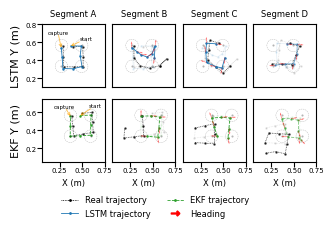

In [1046]:
rnn_df = pd.read_csv('rnn_catputre_rotate.csv', index_col = [0]).loc[40:90].reset_index(drop = True)
ekf_df = pd.read_csv('ekf_catputre_rotate.csv', index_col = [0]).loc[24:74].reset_index(drop = True)

xlims = {'rnn': (0.15, 0.85), 'ekf': (0.05, 0.75)}
ylims = {'rnn': (0.1, 0.8), 'ekf': (0.05, 0.75)}
arrow_length = 0.07

fig, axes = plt.subplots(2, 4, figsize=(ONE_COL_WIDTH, 2.2))
axes = np.asarray(axes)

rnn_segs = [
    rnn_df.iloc[15:23],
    rnn_df.iloc[22:29],
    rnn_df.iloc[28:35],
    rnn_df.iloc[34:40],
]
ekf_segs = [
    ekf_df.iloc[16:24],
    ekf_df.iloc[23:29],
    ekf_df.iloc[28:35],
    ekf_df.iloc[34:42],
]

model_info = {
    'rnn': {
        'x': 'rnn_x',
        'y': 'rnn_y',
        'heading': 'rnn_heading',
        'color': color_scheme['rnn'],
        'linestyle': linestyles['rnn'],
        'label': 'LSTM',
    },
    'ekf': {
        'x': 'ekf_x',
        'y': 'ekf_y',
        'heading': 'ekf_heading',
        'color': color_scheme['ekf'],
        'linestyle': linestyles['ekf'],
        'label': 'EKF',
    },
}


def plot_with_arrows(ax, seg, model_key, model_alpha=1.0, real_alpha=1.0, plot_arrows=False):
    info = model_info[model_key]
    ax.plot(seg['real_x'], seg['real_y'], marker='.', markersize=1.5, c='k', alpha=real_alpha,
            linestyle=linestyles['real'], linewidth=0.6, zorder=1)
    ax.plot(seg[info['x']], seg[info['y']], marker='.', markersize=1.5, c=info['color'], alpha=model_alpha,
            linestyle=info['linestyle'], linewidth=0.6, zorder=2)

    if plot_arrows:
        theta = np.deg2rad(seg[info['heading']])
        dx = arrow_length * np.sin(theta)
        dy = arrow_length * np.cos(theta)
        ax.quiver(
            seg[info['x']], seg[info['y']], dx, dy,
            angles='xy', scale_units='xy', scale=1,
            color='r', width=0.009, headwidth=3, headlength=5, headaxislength=4,
            zorder=5, alpha=0.6
        )

    ax.set_xlim(xlims[model_key])
    ax.set_ylim(ylims[model_key])
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)


def plot_row(row_axes, segs, model_key, exp_key):
    plot_with_arrows(row_axes[0], segs[0], model_key, real_alpha=0.7)

    if model_key == 'rnn':
        start_offset = (6, 4)
        capture_offset = (-10, 10)
    else:
        start_offset = (6, 6)
        capture_offset = (-12, 6)

    info = model_info[model_key]
    start_x, start_y = segs[0][info['x']].iloc[0], segs[0][info['y']].iloc[0]
    end_x, end_y = segs[0][info['x']].iloc[-1], segs[0][info['y']].iloc[-1]

    row_axes[0].annotate(
        'start',
        xy=(start_x, start_y),
        xytext=start_offset,
        textcoords='offset points',
        ha='left',
        fontsize=LABEL_FONT - 4,
        bbox=dict(boxstyle='square,pad=0.1', facecolor='none', edgecolor='none'),
        arrowprops=dict(arrowstyle='->', color='orange', lw=0.6, mutation_scale=5, shrinkA=0, shrinkB=0, alpha=0.7)
    )

    row_axes[0].annotate(
        'capture',
        xy=(end_x, end_y),
        xytext=capture_offset,
        textcoords='offset points',
        ha='left',
        fontsize=LABEL_FONT - 4,
        bbox=dict(boxstyle='square,pad=0.1', facecolor='none', edgecolor='none'),
        arrowprops=dict(arrowstyle='->', color='orange', lw=0.6, mutation_scale=5, shrinkA=0, shrinkB=0, alpha=0.7)
    )

    plot_with_arrows(row_axes[1], segs[0], model_key, model_alpha=0.1, real_alpha=0.1)
    plot_with_arrows(row_axes[1], segs[1], model_key, plot_arrows=True, real_alpha=0.7)

    plot_with_arrows(row_axes[2], segs[1], model_key, model_alpha=0.1, real_alpha=0.1)
    plot_with_arrows(row_axes[2], segs[2], model_key, plot_arrows=True, real_alpha=0.7)

    plot_with_arrows(row_axes[3], segs[2], model_key, model_alpha=0.1, real_alpha=0.1)
    plot_with_arrows(row_axes[3], segs[3], model_key, plot_arrows=True, real_alpha=0.7, model_alpha=0.6)

    for ax in row_axes:
        plot_capture_targets(ax, exp_key)


plot_row(axes[0], rnn_segs, 'rnn', 'rotate')
plot_row(axes[1], ekf_segs, 'ekf', 'rotate')

for col, title in enumerate(['Segment A', 'Segment B', 'Segment C', 'Segment D']):
    axes[0, col].set_title(title, fontsize=TITLE_FONT - 2)

axes[0, 0].set_ylabel('LSTM Y (m)', fontsize=LABEL_FONT)
axes[1, 0].set_ylabel('EKF Y (m)', fontsize=LABEL_FONT)

for r in range(2):
    for c in range(4):
        ax = axes[r, c]
        ax.tick_params(axis='both', labelsize=TICK_FONT - 2, pad=0)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.xaxis.set_major_locator(MaxNLocator(3))
        if c != 0:
            ax.tick_params(labelleft=False, left=False)
        if r != 1:
            ax.tick_params(labelbottom=False, bottom=False)
        else:
            ax.set_xlabel('X (m)', fontsize=LABEL_FONT - 2)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='k', linestyle=linestyles['real'], marker='.', linewidth=0.6, markersize=2, label='Real trajectory'),
    Line2D([0], [0], color=color_scheme['rnn'], linestyle=linestyles['rnn'], marker='.', linewidth=0.6, markersize=2, label='LSTM trajectory'),
    Line2D([0], [0], color=color_scheme['ekf'], linestyle=linestyles['ekf'], marker='.', linewidth=0.6, markersize=2, label='EKF trajectory'),
    Line2D([0], [0], color='r', marker=r'$\rightarrow$', linestyle='None', label='Heading', markersize=6)
]

fig.legend(handles=legend_elements, loc='lower center', ncol=2, frameon=False,
           fontsize=LEGEND_FONT - 1, bbox_to_anchor=(0.5, -0.05))
plt.subplots_adjust(hspace=0.05, wspace=0.12, left=0.16, right=0.98, bottom=0.22, top=0.88)

plt.savefig(FIGURES_DIR / 'live_navigation-capture_rotate_paths.png', dpi=HIRES_DPI, bbox_inches='tight')
plt.show()


In [1047]:
# Combined LSTM/EKF capture plot generated in the previous cell.


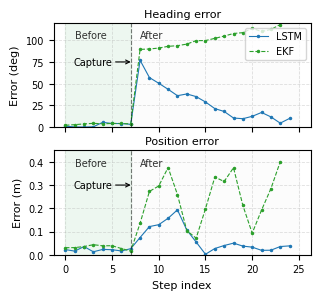

In [1048]:

rnn_df = pd.read_csv('rnn_catputre_rotate.csv', index_col = [0]).loc[40:90].reset_index(drop = True)
vlp_df = pd.read_csv('vlp_catputre_rotate.csv', index_col = [0]).loc[24:74].reset_index(drop = True)
ekf_df = pd.read_csv('ekf_catputre_rotate.csv', index_col = [0]).loc[24:74].reset_index(drop = True)



fig, axes = plt.subplots(2, 1, figsize=(ONE_COL_WIDTH, 4.2), sharex=True)

for ax in axes:
    ax.tick_params(axis='both', labelsize=TICK_FONT)

# Compute errors
rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_df, 'ekf')

# Trimmed index range for plotting
idx_range = np.arange(15, 40)
capture_idx = 7  # relative to slice

# --- Top plot: Heading Error ---
axes[0].plot(abs(rnn_ang_errs[15:40].values), marker='.', linestyle=linestyles['rnn'], linewidth=0.8, markersize=3,
             color=color_scheme['rnn'], label='LSTM')
axes[0].plot(abs(ekf_ang_errs[16:40].values), marker='.', linestyle=linestyles['ekf'], linewidth=0.8, markersize=3,
             color=color_scheme['ekf'], label='EKF')

axes[0].axvline(capture_idx, color='k', linestyle='--', alpha=0.5, linewidth=0.8)
axes[0].annotate('Capture', xy=(capture_idx, 75),
                 xytext=(3, 75),
                 textcoords='data',
                 arrowprops=dict(arrowstyle='->', lw=0.8, color='k',
                                 shrinkA=0, shrinkB=0, relpos=(1, 0.5),
                                 connectionstyle='arc3,rad=0'),
                 fontsize=LABEL_FONT - 1, ha='center', va='center')

axes[0].set_ylabel("Error (deg)", fontsize=LABEL_FONT, labelpad=4)
axes[0].set_title("Heading error", fontsize=TITLE_FONT, pad=4)
axes[0].legend(loc='upper right', fontsize=LEGEND_FONT)
axes[0].grid(True, linestyle='--', alpha=0.4, linewidth=0.6)
axes[0].set_ylim(0, 120)

# --- Bottom plot: Location Error ---
axes[1].plot(abs(rnn_loc_errs[15:40]), marker='.', linestyle=linestyles['rnn'], linewidth=0.8, markersize=3,
             color=color_scheme['rnn'])
axes[1].plot(abs(ekf_loc_errs[16:40]), marker='.', linestyle=linestyles['ekf'], linewidth=0.8, markersize=3,
             color=color_scheme['ekf'])

axes[1].axvline(capture_idx, color='k', linestyle='--', alpha=0.5, linewidth=0.8)
axes[1].annotate('Capture', xy=(capture_idx, 0.3),
                 xytext=(3, 0.3),
                 textcoords='data',
                 arrowprops=dict(arrowstyle='->', lw=0.8, color='k',
                                 shrinkA=0, shrinkB=0, relpos=(1, 0.5),
                                 connectionstyle='arc3,rad=0'),
                 fontsize=LABEL_FONT - 1, ha='center', va='center')

axes[1].set_ylabel("Error (m)", fontsize=LABEL_FONT, labelpad=4)
axes[1].set_xlabel("Step index", fontsize=LABEL_FONT, labelpad=4)
axes[1].set_title("Position error", fontsize=TITLE_FONT, pad=4)
axes[1].grid(True, linestyle='--', alpha=0.4, linewidth=0.6)
axes[1].set_ylim(0, 0.45)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.74])
plt.subplots_adjust(hspace=0.22)


# Shade pre- and post-rotation regions (light gray)
pre_color = '#d4edda'   # pastel green (Before)
post_color = '#cfd2d4'  # cool gray (After)
for ax in axes:
    ax.axvspan(0, capture_idx, color=pre_color, alpha=0.4, zorder=0, label='_nolegend_')
    ax.axvspan(capture_idx, len(idx_range), color=post_color, alpha=0.05, zorder=0, label='_nolegend_')

# Annotate regions with faint text
for ax in axes:
    y_top = ax.get_ylim()[1]
    ax.text(1.0, y_top * 0.85, 'Before', fontsize=LABEL_FONT - 1, color='k', alpha = 0.8)
    ax.text(capture_idx + 1.0, y_top * 0.85, 'After', fontsize=LABEL_FONT - 1, color='k', alpha = 0.8)


plt.savefig(FIGURES_DIR / "live_navigation-capture_rotate_errors.png", dpi=HIRES_DPI)
plt.show()


# Translate only

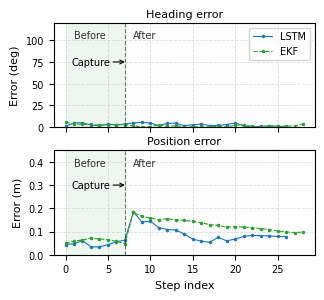

In [1049]:
rnn_df = pd.read_csv('rnn_capture_trans.csv', index_col = [0]).loc[25:65].reset_index(drop = True)
ekf_df = pd.read_csv('ekf_capture_trans.csv', index_col = [0]).loc[5:45].reset_index(drop = True)

fig, axes = plt.subplots(2, 1, figsize=(ONE_COL_WIDTH, 4.2), sharex=True)

for ax in axes:
    ax.tick_params(axis='both', labelsize=TICK_FONT)

# Compute errors
rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_df, 'ekf')

# Trimmed index range for plotting
idx_range = np.arange(15, 40)
capture_idx = 7  # relative to slice

# --- Top plot: Heading Error ---
axes[0].plot(abs(rnn_ang_errs[13:40].values), marker='.', linestyle=linestyles['rnn'], linewidth=0.8, markersize=3,
             color=color_scheme['rnn'], label='LSTM')
axes[0].plot(abs(ekf_ang_errs[11:40].values), marker='.', linestyle=linestyles['ekf'], linewidth=0.8, markersize=3,
             color=color_scheme['ekf'], label='EKF')

axes[0].axvline(capture_idx, color='k', linestyle='--', alpha=0.5, linewidth=0.8)
axes[0].annotate('Capture', xy=(capture_idx, 75),
                 xytext=(3, 75),
                 textcoords='data',
                 arrowprops=dict(arrowstyle='->', lw=0.8, color='k',
                                 shrinkA=0, shrinkB=0, relpos=(1, 0.5),
                                 connectionstyle='arc3,rad=0'),
                 fontsize=LABEL_FONT - 1, ha='center', va='center')

axes[0].set_ylabel("Error (deg)", fontsize=LABEL_FONT, labelpad=4)
axes[0].set_title("Heading error", fontsize=TITLE_FONT, pad=4)
axes[0].legend(loc='upper right', fontsize=LEGEND_FONT)
axes[0].grid(True, linestyle='--', alpha=0.4, linewidth=0.6)
axes[0].set_ylim(0, 120)

# --- Bottom plot: Location Error ---
axes[1].plot(abs(rnn_loc_errs[13:40]), marker='.', linestyle=linestyles['rnn'], linewidth=0.8, markersize=3,
             color=color_scheme['rnn'])
axes[1].plot(abs(ekf_loc_errs[11:40]), marker='.', linestyle=linestyles['ekf'], linewidth=0.8, markersize=3,
             color=color_scheme['ekf'])

axes[1].axvline(capture_idx, color='k', linestyle='--', alpha=0.5, linewidth=0.8)
axes[1].annotate('Capture', xy=(capture_idx, 0.3),
                 xytext=(3, 0.3),
                 textcoords='data',
                 arrowprops=dict(arrowstyle='->', lw=0.8, color='k',
                                 shrinkA=0, shrinkB=0, relpos=(1, 0.5),
                                 connectionstyle='arc3,rad=0'),
                 fontsize=LABEL_FONT - 1, ha='center', va='center')

axes[1].set_ylabel("Error (m)", fontsize=LABEL_FONT, labelpad=4)
axes[1].set_xlabel("Step index", fontsize=LABEL_FONT, labelpad=4)
axes[1].set_title("Position error", fontsize=TITLE_FONT, pad=4)
axes[1].grid(True, linestyle='--', alpha=0.4, linewidth=0.6)
axes[1].set_ylim(0, 0.45)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.74])
plt.subplots_adjust(hspace=0.22)


# Shade pre- and post-rotation regions (light gray)
pre_color = '#d4edda'   # pastel green (Before)
post_color = '#cfd2d4'  # cool gray (After)
for ax in axes:
    ax.axvspan(0, capture_idx, color=pre_color, alpha=0.4, zorder=0, label='_nolegend_')
    ax.axvspan(capture_idx, len(idx_range), color=post_color, alpha=0.05, zorder=0, label='_nolegend_')

# Annotate regions with faint text
for ax in axes:
    y_top = ax.get_ylim()[1]
    ax.text(1.0, y_top * 0.85, 'Before', fontsize=LABEL_FONT - 1, color='k', alpha = 0.8)
    ax.text(capture_idx + 1.0, y_top * 0.85, 'After', fontsize=LABEL_FONT - 1, color='k', alpha = 0.8)


plt.savefig(FIGURES_DIR / "live_navigation-capture_translate_errors.png", dpi=HIRES_DPI)
plt.show()


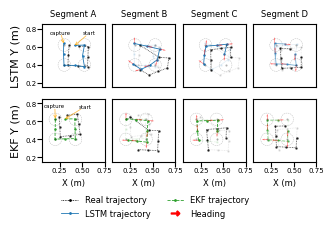

In [1050]:
rnn_df = pd.read_csv('rnn_capture_trans.csv', index_col = [0]).loc[25:65].reset_index(drop = True)
ekf_df = pd.read_csv('ekf_capture_trans.csv', index_col = [0]).loc[5:45].reset_index(drop = True)

xlims = {'rnn': (-0.05, 0.65), 'ekf': (0.05, 0.75)}
ylims = {'rnn': (0.15, 0.85), 'ekf': (0.15, 0.85)}
arrow_length = 0.07

fig, axes = plt.subplots(2, 4, figsize=(ONE_COL_WIDTH, 2.2))
axes = np.asarray(axes)

rnn_segs = [
    rnn_df.iloc[13:21],
    rnn_df.iloc[20:27],
    rnn_df.iloc[26:32],
    rnn_df.iloc[31:38],
]
ekf_segs = [
    ekf_df.iloc[11:19],
    ekf_df.iloc[18:25],
    ekf_df.iloc[24:30],
    ekf_df.iloc[29:36],
]

model_info = {
    'rnn': {
        'x': 'rnn_x',
        'y': 'rnn_y',
        'heading': 'rnn_heading',
        'color': color_scheme['rnn'],
        'linestyle': linestyles['rnn'],
        'label': 'LSTM',
    },
    'ekf': {
        'x': 'ekf_x',
        'y': 'ekf_y',
        'heading': 'ekf_heading',
        'color': color_scheme['ekf'],
        'linestyle': linestyles['ekf'],
        'label': 'EKF',
    },
}


def plot_with_arrows(ax, seg, model_key, model_alpha=1.0, real_alpha=1.0, plot_arrows=False):
    info = model_info[model_key]
    ax.plot(seg['real_x'], seg['real_y'], marker='.', markersize=1.5, c='k', alpha=real_alpha,
            linestyle=linestyles['real'], linewidth=0.6, zorder=1)
    ax.plot(seg[info['x']], seg[info['y']], marker='.', markersize=1.5, c=info['color'], alpha=model_alpha,
            linestyle=info['linestyle'], linewidth=0.6, zorder=2)

    if plot_arrows:
        theta = np.deg2rad(seg[info['heading']])
        dx = arrow_length * np.sin(theta)
        dy = arrow_length * np.cos(theta)
        ax.quiver(
            seg[info['x']], seg[info['y']], dx, dy,
            angles='xy', scale_units='xy', scale=1,
            color='r', width=0.009, headwidth=3, headlength=5, headaxislength=4,
            zorder=5, alpha=0.6
        )

    ax.set_xlim(xlims[model_key])
    ax.set_ylim(ylims[model_key])
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)


def plot_row(row_axes, segs, model_key, exp_key):
    plot_with_arrows(row_axes[0], segs[0], model_key, real_alpha=0.7)

    if model_key == 'rnn':
        start_offset = (6, 8)
        capture_offset = (-10, 7)
    else:
        start_offset = (10, 8)
        capture_offset = (-8, 8)

    info = model_info[model_key]
    start_x, start_y = segs[0][info['x']].iloc[0], segs[0][info['y']].iloc[0]
    end_x, end_y = segs[0][info['x']].iloc[-1], segs[0][info['y']].iloc[-1]

    row_axes[0].annotate(
        'start',
        xy=(start_x, start_y),
        xytext=start_offset,
        textcoords='offset points',
        ha='left',
        fontsize=LABEL_FONT - 4,
        bbox=dict(boxstyle='square,pad=0.1', facecolor='none', edgecolor='none'),
        arrowprops=dict(arrowstyle='->', color='orange', lw=0.6, mutation_scale=5, shrinkA=0, shrinkB=0, alpha=0.7)
    )

    row_axes[0].annotate(
        'capture',
        xy=(end_x, end_y),
        xytext=capture_offset,
        textcoords='offset points',
        ha='left',
        fontsize=LABEL_FONT - 4,
        bbox=dict(boxstyle='square,pad=0.1', facecolor='none', edgecolor='none'),
        arrowprops=dict(arrowstyle='->', color='orange', lw=0.6, mutation_scale=5, shrinkA=0, shrinkB=0, alpha=0.7)
    )

    plot_with_arrows(row_axes[1], segs[0], model_key, model_alpha=0.1, real_alpha=0.1)
    plot_with_arrows(row_axes[1], segs[1], model_key, plot_arrows=True, real_alpha=0.7)

    plot_with_arrows(row_axes[2], segs[1], model_key, model_alpha=0.1, real_alpha=0.1)
    plot_with_arrows(row_axes[2], segs[2], model_key, plot_arrows=True, real_alpha=0.7)

    plot_with_arrows(row_axes[3], segs[2], model_key, model_alpha=0.1, real_alpha=0.1)
    plot_with_arrows(row_axes[3], segs[3], model_key, plot_arrows=True, real_alpha=0.7, model_alpha=0.6)

    for ax in row_axes:
        plot_capture_targets(ax, exp_key)


plot_row(axes[0], rnn_segs, 'rnn', 'trans')
plot_row(axes[1], ekf_segs, 'ekf', 'trans')

for col, title in enumerate(['Segment A', 'Segment B', 'Segment C', 'Segment D']):
    axes[0, col].set_title(title, fontsize=TITLE_FONT - 2)

axes[0, 0].set_ylabel('LSTM Y (m)', fontsize=LABEL_FONT)
axes[1, 0].set_ylabel('EKF Y (m)', fontsize=LABEL_FONT)

for r in range(2):
    for c in range(4):
        ax = axes[r, c]
        ax.tick_params(axis='both', labelsize=TICK_FONT - 2, pad=0)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.xaxis.set_major_locator(MaxNLocator(3))
        if c != 0:
            ax.tick_params(labelleft=False, left=False)
        if r != 1:
            ax.tick_params(labelbottom=False, bottom=False)
        else:
            ax.set_xlabel('X (m)', fontsize=LABEL_FONT - 2)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='k', linestyle=linestyles['real'], marker='.', linewidth=0.6, markersize=2, label='Real trajectory'),
    Line2D([0], [0], color=color_scheme['rnn'], linestyle=linestyles['rnn'], marker='.', linewidth=0.6, markersize=2, label='LSTM trajectory'),
    Line2D([0], [0], color=color_scheme['ekf'], linestyle=linestyles['ekf'], marker='.', linewidth=0.6, markersize=2, label='EKF trajectory'),
    Line2D([0], [0], color='r', marker=r'$\rightarrow$', linestyle='None', label='Heading', markersize=6)
]

fig.legend(handles=legend_elements, loc='lower center', ncol=2, frameon=False,
           fontsize=LEGEND_FONT - 1, bbox_to_anchor=(0.5, -0.05))
plt.subplots_adjust(hspace=0.05, wspace=0.12, left=0.16, right=0.98, bottom=0.22, top=0.88)

plt.savefig(FIGURES_DIR / 'live_navigation-capture_translate_paths.png', dpi=HIRES_DPI, bbox_inches='tight')
plt.show()


In [1056]:
FIGURES_DIR

PosixPath('/Users/tyrelglass/PhD/Repositories/robot-vlp/reports/67c4db6d4bd74c401fb0585d/figures')

In [1051]:
# Combined LSTM/EKF capture plot generated in the previous cell.


# Translate and rotate

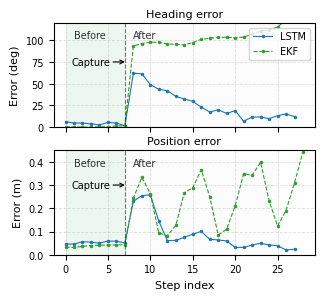

In [1052]:
rnn_df = pd.read_csv('rnn_capture_trans_and_rotate.csv', index_col = [0]).loc[27:].reset_index(drop = True)
ekf_df = pd.read_csv('ekf_capture_trans_and_rotate.csv', index_col = [0]).loc[5:].reset_index(drop = True)


fig, axes = plt.subplots(2, 1, figsize=(ONE_COL_WIDTH, 4.2), sharex=True)

for ax in axes:
    ax.tick_params(axis='both', labelsize=TICK_FONT)

# Compute errors
rnn_ang_errs, rnn_loc_errs = calc_errors(rnn_df, 'rnn')
ekf_ang_errs, ekf_loc_errs = calc_errors(ekf_df, 'ekf')

# Trimmed index range for plotting
idx_range = np.arange(15, 40)
capture_idx = 7  # relative to slice

# --- Top plot: Heading Error ---
axes[0].plot(abs(rnn_ang_errs[12:40].values), marker='.', linestyle=linestyles['rnn'], linewidth=0.8, markersize=3,
             color=color_scheme['rnn'], label='LSTM')
axes[0].plot(abs(ekf_ang_errs[11:40].values), marker='.', linestyle=linestyles['ekf'], linewidth=0.8, markersize=3,
             color=color_scheme['ekf'], label='EKF')

axes[0].axvline(capture_idx, color='k', linestyle='--', alpha=0.5, linewidth=0.8)
axes[0].annotate('Capture', xy=(capture_idx, 75),
                 xytext=(3, 75),
                 textcoords='data',
                 arrowprops=dict(arrowstyle='->', lw=0.8, color='k',
                                 shrinkA=0, shrinkB=0, relpos=(1, 0.5),
                                 connectionstyle='arc3,rad=0'),
                 fontsize=LABEL_FONT - 1, ha='center', va='center')

axes[0].set_ylabel("Error (deg)", fontsize=LABEL_FONT, labelpad=4)
axes[0].set_title("Heading error", fontsize=TITLE_FONT, pad=4)
axes[0].legend(loc='upper right', fontsize=LEGEND_FONT)
axes[0].grid(True, linestyle='--', alpha=0.4, linewidth=0.6)
axes[0].set_ylim(0, 120)

# --- Bottom plot: Location Error ---
axes[1].plot(abs(rnn_loc_errs[12:40]), marker='.', linestyle=linestyles['rnn'], linewidth=0.8, markersize=3,
             color=color_scheme['rnn'])
axes[1].plot(abs(ekf_loc_errs[11:40]), marker='.', linestyle=linestyles['ekf'], linewidth=0.8, markersize=3,
             color=color_scheme['ekf'])

axes[1].axvline(capture_idx, color='k', linestyle='--', alpha=0.5, linewidth=0.8)
axes[1].annotate('Capture', xy=(capture_idx, 0.3),
                 xytext=(3, 0.3),
                 textcoords='data',
                 arrowprops=dict(arrowstyle='->', lw=0.8, color='k',
                                 shrinkA=0, shrinkB=0, relpos=(1, 0.5),
                                 connectionstyle='arc3,rad=0'),
                 fontsize=LABEL_FONT - 1, ha='center', va='center')

axes[1].set_ylabel("Error (m)", fontsize=LABEL_FONT, labelpad=4)
axes[1].set_xlabel("Step index", fontsize=LABEL_FONT, labelpad=4)
axes[1].set_title("Position error", fontsize=TITLE_FONT, pad=4)
axes[1].grid(True, linestyle='--', alpha=0.4, linewidth=0.6)
axes[1].set_ylim(0, 0.45)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.74])
plt.subplots_adjust(hspace=0.22)


# Shade pre- and post-rotation regions (light gray)
pre_color = '#d4edda'   # pastel green (Before)
post_color = '#cfd2d4'  # cool gray (After)
for ax in axes:
    ax.axvspan(0, capture_idx, color=pre_color, alpha=0.4, zorder=0, label='_nolegend_')
    ax.axvspan(capture_idx, len(idx_range), color=post_color, alpha=0.05, zorder=0, label='_nolegend_')

# Annotate regions with faint text
for ax in axes:
    y_top = ax.get_ylim()[1]
    ax.text(1.0, y_top * 0.85, 'Before', fontsize=LABEL_FONT - 1, color='k', alpha = 0.8)
    ax.text(capture_idx + 1.0, y_top * 0.85, 'After', fontsize=LABEL_FONT - 1, color='k', alpha = 0.8)


plt.savefig(FIGURES_DIR / "live_navigation-capture_translate_ang_rotate_errors.png", dpi=HIRES_DPI)
plt.show()


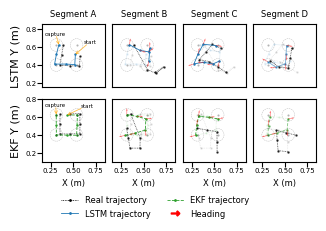

In [1053]:
rnn_df = pd.read_csv('rnn_capture_trans_and_rotate.csv', index_col = [0]).loc[27:].reset_index(drop = True)
ekf_df = pd.read_csv('ekf_capture_trans_and_rotate.csv', index_col = [0]).loc[5:].reset_index(drop = True)

xlims = {'rnn': (0.15, 0.85), 'ekf': (0.15, 0.85)}
ylims = {'rnn': (0.15, 0.85), 'ekf': (0.1, 0.8)}
arrow_length = 0.07

fig, axes = plt.subplots(2, 4, figsize=(ONE_COL_WIDTH, 2.2))
axes = np.asarray(axes)

rnn_segs = [
    rnn_df.iloc[14:20],
    rnn_df.iloc[19:24],
    rnn_df.iloc[23:30],
    rnn_df.iloc[29:34],
]
ekf_segs = [
    ekf_df.iloc[11:19],
    ekf_df.iloc[18:24],
    ekf_df.iloc[23:28],
    ekf_df.iloc[27:33],
]

model_info = {
    'rnn': {
        'x': 'rnn_x',
        'y': 'rnn_y',
        'heading': 'rnn_heading',
        'color': color_scheme['rnn'],
        'linestyle': linestyles['rnn'],
        'label': 'LSTM',
    },
    'ekf': {
        'x': 'ekf_x',
        'y': 'ekf_y',
        'heading': 'ekf_heading',
        'color': color_scheme['ekf'],
        'linestyle': linestyles['ekf'],
        'label': 'EKF',
    },
}


def plot_with_arrows(ax, seg, model_key, model_alpha=1.0, real_alpha=1.0, plot_arrows=False):
    info = model_info[model_key]
    ax.plot(seg['real_x'], seg['real_y'], marker='.', markersize=1.5, c='k', alpha=real_alpha,
            linestyle=linestyles['real'], linewidth=0.6, zorder=1)
    ax.plot(seg[info['x']], seg[info['y']], marker='.', markersize=1.5, c=info['color'], alpha=model_alpha,
            linestyle=info['linestyle'], linewidth=0.6, zorder=2)

    if plot_arrows:
        theta = np.deg2rad(seg[info['heading']])
        dx = arrow_length * np.sin(theta)
        dy = arrow_length * np.cos(theta)
        ax.quiver(
            seg[info['x']], seg[info['y']], dx, dy,
            angles='xy', scale_units='xy', scale=1,
            color='r', width=0.009, headwidth=3, headlength=5, headaxislength=4,
            zorder=5, alpha=0.6
        )

    ax.set_xlim(xlims[model_key])
    ax.set_ylim(ylims[model_key])
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)


def plot_row(row_axes, segs, model_key, exp_key):
    plot_with_arrows(row_axes[0], segs[0], model_key, real_alpha=0.7)

    if model_key == 'rnn':
        start_offset = (6, 8)
        capture_offset = (-10, 7)
    else:
        start_offset = (10, 6)
        capture_offset = (-8, 6)

    info = model_info[model_key]
    start_x, start_y = segs[0][info['x']].iloc[0], segs[0][info['y']].iloc[0]
    end_x, end_y = segs[0][info['x']].iloc[-1], segs[0][info['y']].iloc[-1]

    row_axes[0].annotate(
        'start',
        xy=(start_x, start_y),
        xytext=start_offset,
        textcoords='offset points',
        ha='left',
        fontsize=LABEL_FONT - 4,
        bbox=dict(boxstyle='square,pad=0.1', facecolor='none', edgecolor='none'),
        arrowprops=dict(arrowstyle='->', color='orange', lw=0.6, mutation_scale=5, shrinkA=0, shrinkB=0, alpha=0.7)
    )

    row_axes[0].annotate(
        'capture',
        xy=(end_x, end_y),
        xytext=capture_offset,
        textcoords='offset points',
        ha='left',
        fontsize=LABEL_FONT - 4,
        bbox=dict(boxstyle='square,pad=0.1', facecolor='none', edgecolor='none'),
        arrowprops=dict(arrowstyle='->', color='orange', lw=0.6, mutation_scale=5, shrinkA=0, shrinkB=0, alpha=0.7)
    )

    plot_with_arrows(row_axes[1], segs[0], model_key, model_alpha=0.1, real_alpha=0.1)
    plot_with_arrows(row_axes[1], segs[1], model_key, plot_arrows=True, real_alpha=0.7)

    plot_with_arrows(row_axes[2], segs[1], model_key, model_alpha=0.1, real_alpha=0.1)
    plot_with_arrows(row_axes[2], segs[2], model_key, plot_arrows=True, real_alpha=0.7)

    plot_with_arrows(row_axes[3], segs[2], model_key, model_alpha=0.1, real_alpha=0.1)
    plot_with_arrows(row_axes[3], segs[3], model_key, plot_arrows=True, real_alpha=0.7, model_alpha=0.6)

    for ax in row_axes:
        plot_capture_targets(ax, exp_key)


plot_row(axes[0], rnn_segs, 'rnn', 'trans_and_rotate')
plot_row(axes[1], ekf_segs, 'ekf', 'trans_and_rotate')

for col, title in enumerate(['Segment A', 'Segment B', 'Segment C', 'Segment D']):
    axes[0, col].set_title(title, fontsize=TITLE_FONT - 2)

axes[0, 0].set_ylabel('LSTM Y (m)', fontsize=LABEL_FONT)
axes[1, 0].set_ylabel('EKF Y (m)', fontsize=LABEL_FONT)

for r in range(2):
    for c in range(4):
        ax = axes[r, c]
        ax.tick_params(axis='both', labelsize=TICK_FONT - 2, pad=0)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.xaxis.set_major_locator(MaxNLocator(3))
        if c != 0:
            ax.tick_params(labelleft=False, left=False)
        if r != 1:
            ax.tick_params(labelbottom=False, bottom=False)
        else:
            ax.set_xlabel('X (m)', fontsize=LABEL_FONT - 2)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='k', linestyle=linestyles['real'], marker='.', linewidth=0.6, markersize=2, label='Real trajectory'),
    Line2D([0], [0], color=color_scheme['rnn'], linestyle=linestyles['rnn'], marker='.', linewidth=0.6, markersize=2, label='LSTM trajectory'),
    Line2D([0], [0], color=color_scheme['ekf'], linestyle=linestyles['ekf'], marker='.', linewidth=0.6, markersize=2, label='EKF trajectory'),
    Line2D([0], [0], color='r', marker=r'$\rightarrow$', linestyle='None', label='Heading', markersize=6)
]

fig.legend(handles=legend_elements, loc='lower center', ncol=2, frameon=False,
           fontsize=LEGEND_FONT - 1, bbox_to_anchor=(0.5, -0.05))
plt.subplots_adjust(hspace=0.05, wspace=0.12, left=0.16, right=0.98, bottom=0.22, top=0.88)

plt.savefig(FIGURES_DIR / 'live_navigation-capture_translate_and_rotate_paths.png', dpi=HIRES_DPI, bbox_inches='tight')
plt.show()


In [1054]:
# Combined LSTM/EKF capture plot generated in the previous cell.


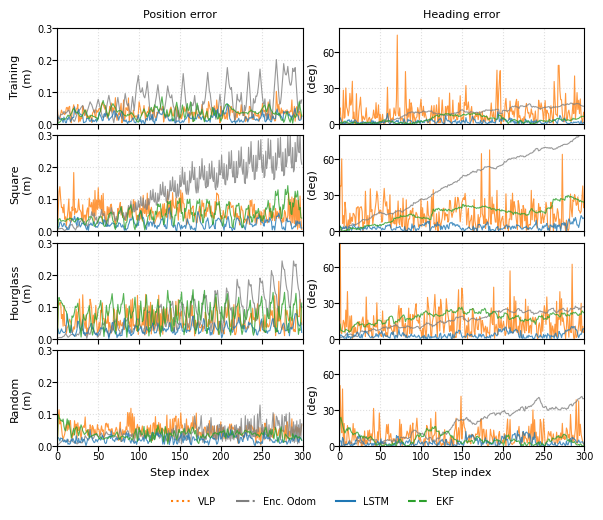

In [1055]:
# Consolidated 4x2 grid comparing heading/position errors across training + field deployments
from robot_vlp.config import INTERIM_DATA_DIR, MODELS_DIR
import robot_vlp.data.preprocessing as prep
import robot_vlp.stats.navigation_performance as nav
import robot_vlp.modeling.EKF as ekf
from tensorflow.keras.models import load_model


def _vec_to_ang(pred_vec):
    return np.arctan2(pred_vec[:, 0], pred_vec[:, 1])


def _preprocess_training_df(df):
    feature_cols = [
        'vlp_x_hist', 'vlp_y_hist', 'vlp_heading_hist_rad', 'vlp_heading_change_rad',
        'encoder_heading_change_rad', 'encoder_heading_hist_rad', 'encoder_x_hist', 'encoder_y_hist'
    ]
    target_cols = ['x_hist', 'y_hist', 'heading_hist_rad']
    X = df[feature_cols].values
    y = df[target_cols].values
    X_win, y_win, _ = prep.window_data(X, y, y, overlap=0.999999, window_len=20)
    return np.nan_to_num(X_win, nan=0.0), np.nan_to_num(y_win, nan=0.0)


def _run_training_ekf(df):
    err_stats = {
        'R_x': 0.0012091360236459105,
        'R_y': 0.0011077760034705292,
        'R_theta': 0.04970905192458874,
        'Q_theta': 0.00021652921772540736,
        'Q_theta_no_turn': 3.982763121767624e-05,
        'Q_dist': 1.7424913153369338e-06,
    }
    ekf_df = ekf.run_ekf(df.reset_index(drop=True), err_stats)
    pre_loc = ekf_df[['EKF_x', 'EKF_y']].values
    ang = ekf_df['EKF_heading_rad'].to_numpy()
    loc_errs = nav.calc_loc_err(pre_loc, df[['x_hist', 'y_hist']].values)
    ang_errs = np.array([normalize_angle_rad(a) for a in ang - df['heading_hist_rad'].to_numpy()])
    return ang_errs, loc_errs


def _trim_series(arr, model_key, already_aligned=False):
    arr = np.asarray(arr)
    if already_aligned:
        return arr[:300]
    if model_key == 'rnn' and arr.shape[0] > 20:
        end = min(arr.shape[0], 320)
        return arr[20:end]
    return arr[:300]


def _load_training_errors():
    model = load_model(MODELS_DIR / 'navigation_neural_nets/rnn.keras')
    df_list = [pd.read_csv(INTERIM_DATA_DIR / 'exp_vive_navigated_paths' / f'exp1_{i}_high_acc.csv') for i in range(10)]
    df = df_list[-1].copy()
    patch = (
        df[['x_hist', 'y_hist', 'heading_hist_rad']].iloc[19].values
        - df[['encoder_x_hist', 'encoder_y_hist', 'encoder_heading_hist_rad']].iloc[19].values
    )
    df[['encoder_x_hist', 'encoder_y_hist', 'encoder_heading_hist_rad']] += patch
    X_win, y_win = _preprocess_training_df(df)
    ekf_ang_errs, ekf_loc_errs = _run_training_ekf(df.iloc[20:320].copy())
    rnn_pre_loc, rnn_pre_ang = model.predict(X_win, verbose=0)

    heading_data = {
        'vlp': np.abs(np.rad2deg(np.array([normalize_angle_rad(a) for a in (y_win[:, 2] - X_win[:, -1, 2])])[:300])),
        'encoder': np.abs(np.rad2deg(np.array([normalize_angle_rad(a) for a in (X_win[:, -1, 5] - y_win[:, 2])])[:300])),
        'rnn': np.abs(np.rad2deg(
            np.array([normalize_angle_rad(a) for a in (_vec_to_ang(rnn_pre_ang) - y_win[:, 2])])[:300]
        )),
        'ekf': np.abs(np.rad2deg(ekf_ang_errs[:300])),
    }

    position_data = {
        'vlp': nav.calc_loc_err(X_win[:, -1, :2], y_win[:, :2])[:300],
        'encoder': nav.calc_loc_err(X_win[:, -1, -2:], y_win[:, :2])[:300],
        'rnn': nav.calc_loc_err(rnn_pre_loc, y_win[:, :2])[:300],
        'ekf': ekf_loc_errs[:300],
    }
    return {'heading': heading_data, 'position': position_data}


def _load_field_path_errors():
    csv_map = {
        'square': {
            'rnn': 'final_rnn_square_m3_2.csv',
            'ekf': 'final_ekf_square_m3.csv',
            'encoder': 'final_encoder_square_m3.csv',
            'vlp': 'final_vlp_square_m3_2.csv',
        },
        'hourglass': {
            'rnn': 'final_rnn_hourglass_m3.csv',
            'ekf': 'final_ekf_hourglass_m3.csv',
            'encoder': 'final_encoder_hourglass_m3.csv',
            'vlp': 'final_vlp_hourglass_m3.csv',
        },
        'random': {
            'rnn': 'final_rnn_random_m3_2.csv',
            'ekf': 'final_ekf_random_m3.csv',
            'encoder': 'final_encoder_random_m3.csv',
            'vlp': 'final_vlp_random_m3.csv',
        },
    }

    path_errors = {}
    for path_key, file_map in csv_map.items():
        heading, position = {}, {}
        for model_key, filename in file_map.items():
            nav_key = 'enc' if model_key == 'encoder' else model_key
            df = pd.read_csv(filename, index_col=0)
            ang_errs, loc_errs = calc_errors(df, nav_key)
            heading[model_key] = np.abs(_trim_series(np.asarray(ang_errs), model_key))
            position[model_key] = _trim_series(np.asarray(loc_errs), model_key)
        path_errors[path_key] = {'heading': heading, 'position': position}
    return path_errors


def _collect_path_errors():
    errors = {'training': _load_training_errors()}
    errors.update(_load_field_path_errors())
    return errors


def plot_path_error_grid(errors, save_name):
    rows = ['training', 'square', 'hourglass', 'random']
    cols = ['position', 'heading']
    row_labels = {
        'training': 'Training',
        'square': 'Square',
        'hourglass': 'Hourglass',
        'random': 'Random',
    }
    col_titles = {'position': 'Position error', 'heading': 'Heading error'}
    fig, axes = plt.subplots(len(rows), len(cols), figsize=(TWO_COL_WIDTH, 5.5), sharex='col')
    for r, path_key in enumerate(rows):
        for c, metric in enumerate(cols):
            ax = axes[r, c]
            for model in ['vlp', 'encoder', 'rnn', 'ekf']:
                series = errors[path_key][metric][model]
                steps = np.arange(len(series))
                alpha = 0.8
                ax.plot(steps, series, label=display_labels.get(model, model), color=color_scheme[model], linestyle="-", alpha=alpha, linewidth=0.8)
            ax.set_xlim(0, 300)
            if metric == 'position':
                ax.set_ylim(0, 0.3)
            else:
                ax.set_ylim(0, 80)
            ax.yaxis.set_major_locator(MaxNLocator(nbins=3, prune=None))
            unit = '(m)' if metric == 'position' else '(deg)'
            if c == 0:
                ax.set_ylabel(f"{row_labels[path_key]}\n{unit}", fontsize=LABEL_FONT)
            else:
                ax.set_ylabel(unit, fontsize=LABEL_FONT)
            ax.grid(True, linestyle=':', alpha=0.4)
            ax.tick_params(axis='both', labelsize=TICK_FONT, pad=0)
            if r == len(rows) - 1:
                ax.set_xlabel('Step index', fontsize=LABEL_FONT)
            if r == 0:
                ax.set_title(col_titles[metric], fontsize=TITLE_FONT, pad=8)

    handles = [plt.Line2D([0], [0], color=color_scheme[m], linestyle=linestyles[m], label=display_labels.get(m, m)) for m in ['vlp', 'encoder', 'rnn', 'ekf']]
    fig.legend(handles=handles, loc='lower center', ncol=4, frameon=False, fontsize=LEGEND_FONT, bbox_to_anchor=(0.5, 0.015))
    plt.subplots_adjust(hspace=0.12, wspace=0.15, bottom=0.14, top=0.9)
    if save_name is not None:
        plt.savefig(save_name, dpi=HIRES_DPI, bbox_inches='tight')
    plt.show()


all_path_errors = _collect_path_errors()
plot_path_error_grid(all_path_errors, FIGURES_DIR / 'live_navigation-path_error_grid.png')
